# Afternoon trials

## Notebook outline

### Synchronisation

- Load in GPS data into a dataframe and set the reference point of the synchronisation peak
- Calculate the time_from_sync for the gps data
- Load in the IMU data into a dataframe and find the locations of the synchronisation peaks
- Calculate the time_from_sync for the imu data and add a time_from_sync column to their csv files
- Now we have established a time_from_sync for both the gps and imu data, we can split them into experiments based on this timing

### Experiment splitting

- Split the gps data into experiments based on the time_from_sync
- Split the imu data into experiments based on the time_from_sync
- Plot each of the experiments with a longitude and latitude plot
- Plot all possible variables against time for each experiment and save to respective folders

### That's all for this notebook

## Extracting the csv data from the txt files and amalgamating the white-no-blue sensor data

In [120]:
import telemetry_parser
import pandas as pd
import os
from DataExtractor import process_sensor_data
import matplotlib.pyplot as plt

def read_files_utd(root_folder):
    for file in os.listdir(root_folder):
        if file.endswith('.TXT'):
            
            print(file)
            
            # Construct file path 
            file_path = os.path.join(root_folder, file)
            
            # Extract just the file name without extension
            file_name = os.path.splitext(file)[0]  

            # Create a folder for this file 
            output_dir = os.path.join(root_folder, file_name)
            if not os.path.exists(output_dir):
                os.mkdir(output_dir)

            tp = telemetry_parser.Parser(file_path)

            # Save data as a DataFrame
            sensor_data = pd.DataFrame(tp.telemetry(human_readable = True)[0])
            
            # print(sensor_data['Gyroscope']['Data'][:100])
            
            # Process the file 
            process_sensor_data(sensor_data, output_dir, file_name)

    return



In [121]:
# get all folders in the folder ../
root_folder = '../'
for folder in os.listdir(root_folder):
    if os.path.isdir(os.path.join(root_folder, folder)):
        read_files_utd(os.path.join(root_folder, folder))
        print('Finished processing folder: ', folder)
        print('-------------------------------------')

Finished processing folder:  GPS
-------------------------------------
Finished processing folder:  Phone Magnetometer
-------------------------------------
WIT3.TXT
Processing sensor data...
Processing 1 of 5...
Processing 2 of 5...
Processing 3 of 5...
Processing 4 of 5...
Processing 5 of 5...
Finished processing folder:  Sensor_3
-------------------------------------
WIT4.TXT
Processing sensor data...
Processing 1 of 5...
Processing 2 of 5...
Processing 3 of 5...
Processing 4 of 5...
Processing 5 of 5...
Finished processing folder:  Sensor_4
-------------------------------------
WIT3.TXT
Processing sensor data...
Processing 1 of 5...
Processing 2 of 5...
Processing 3 of 5...
Processing 4 of 5...
Processing 5 of 5...
Finished processing folder:  Sensor_5
-------------------------------------
WIT00001.TXT
Processing sensor data...
Processing 1 of 5...
Processing 2 of 5...
Processing 3 of 5...
Processing 4 of 5...
Processing 5 of 5...
Finished processing folder:  White-blue
-----------

In [137]:
import os

# Function to stitch files with continuous time from a given folder and save the result
def stitch_files_from_folder_and_save(folder_path, output_folder, time_increment=0.075):
    time_offset = 0
    stitched_data = pd.DataFrame()

    # Loop through all CSV files in the folder
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            
            # Load the CSV file
            df = pd.read_csv(file_path)
            
            # Adjust the time for the current file based on the offset
            df['t'] = df['t'] + time_offset
            
            # Update the time offset for the next file
            time_offset += df['t'].max() + time_increment
            
            # Concatenate the data
            stitched_data = pd.concat([stitched_data, df], ignore_index=True)
    
    # Save the stitched data to a CSV file
    output_file = os.path.join(output_folder, f"Stitched_{os.path.basename(folder_path)}.csv")
    stitched_data.to_csv(output_file, index=False)
    print(f"Stitched data saved to: {output_file}")

# Function to process all folders and save the stitched results
def process_and_save_all_folders(base_path, output_base_path):
    folder_names = ["ALL_Accelerations", "ALL_Angles", "ALL_Gyroscopes", "ALL_Magnetometers", "ALL_Quaternions"]
    
    # Ensure the output folder exists
    if not os.path.exists(output_base_path):
        os.makedirs(output_base_path)

    for folder in folder_names:
        folder_path = os.path.join(base_path, folder)
        stitch_files_from_folder_and_save(folder_path, output_base_path)

# Specify the base path for the folders and the output path for the stitched CSVs
base_folder_path = "../White-no-blue/Output"   # Replace with the actual path containing the folders
output_folder_path = "../White-no-blue/Output/Graphs"  # Folder to save stitched files

# Process and save all stitched data
process_and_save_all_folders(base_folder_path, output_folder_path)


Stitched data saved to: ../White-no-blue/Output/Graphs\Stitched_ALL_Accelerations.csv
Stitched data saved to: ../White-no-blue/Output/Graphs\Stitched_ALL_Angles.csv
Stitched data saved to: ../White-no-blue/Output/Graphs\Stitched_ALL_Gyroscopes.csv
Stitched data saved to: ../White-no-blue/Output/Graphs\Stitched_ALL_Magnetometers.csv
Stitched data saved to: ../White-no-blue/Output/Graphs\Stitched_ALL_Quaternions.csv


## Simple plotting of each of the IMU data files for all of the experiments
- This creates a plot for each of the experiments with the time on the x-axis and the variable on the y-axis
- This is saved to the "Ryde-seatrials-afternoon-turns-12-12-2023\GPS\PLOTS_All_Experiment_IMU_plots" folder
- Included is a set of combined plots for each of the sensors for each of the variables that helps see all the data at once

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Base directory where your IMU sensor data is stored
BASE_DIR = "IMUS"

# Helper function to get y-axis limits and labels based on data type
def get_y_axis_info(file_prefix):
    if file_prefix == 'Accelerometer':
        y_label = 'Acceleration [g]'
        y_range = (-2.5, 2.5)  # g-force with some flex
    elif file_prefix == 'Angle':
        y_label = 'Angle [°]'
        y_range = (-190, 190)  # degrees with some flex
    elif file_prefix == 'Gyroscope':
        y_label = 'Angular Velocity [°/s]'
        y_range = (-550, 550)  # degrees per second with some flex
    elif file_prefix == 'Magnetometer':
        y_label = 'Magnetic Field [µT]'
        y_range = (-11000, 11000)  # microtesla with some flex
    elif file_prefix == 'Quaternion':
        y_label = 'Quaternion'
        y_range = (-1.1, 1.1)  # quaternions are unitless and normalized
    else:
        raise ValueError(f"Unknown file prefix: {file_prefix}")
    
    return y_label, y_range

# Function to generate individual plots for given data
def plot_data(dataframe, columns, file_prefix, sensor_name, save_folder):
    os.makedirs(save_folder, exist_ok=True)
    
    # Get y-axis limits and labels from the helper function
    y_label, y_range = get_y_axis_info(file_prefix)
    
    for column in columns:
        dataframe.plot(x='t', y=column)
        plt.title(f'Afternoon trials all experiment data {sensor_name} {file_prefix} {column} vs time')
        plt.xlabel('Time [s]')
        plt.ylabel(y_label)
        plt.ylim(y_range)  # Set the y-axis range based on data type
        plt.savefig(f'{save_folder}/{sensor_name}_afternoon_{file_prefix}_{column}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close()

# Function to generate combined subplot for each sensor's data
def plot_combined_subplot(dataframe, columns, file_prefix, sensor_name, save_folder):
    os.makedirs(save_folder, exist_ok=True)
    fig, axs = plt.subplots(len(columns), 1, figsize=(10, 8), sharex=True)
    colors = ['blue', 'orange', 'green']  # Define colors for x, y, z axes

    # Get y-axis limits and labels from the helper function
    y_label, y_range = get_y_axis_info(file_prefix)

    for idx, column in enumerate(columns):
        axs[idx].plot(dataframe['t'], dataframe[column], color=colors[idx], label=column)
        axs[idx].set_ylabel(y_label)  # Adjust label as needed
        axs[idx].set_ylim(y_range)  # Set y-axis limits
        axs[idx].legend(loc='upper right')
        axs[idx].set_title(f'{column} along {file_prefix} axis')
        
    axs[-1].set_xlabel('Time [s]')

    # Set a single title for the entire subplot figure
    plt.suptitle(f'Afternoon trials all experiment data {sensor_name} {file_prefix}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'{save_folder}/{sensor_name}_afternoon_combined_{file_prefix}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close()

# Define sensor folders and data types
sensors = ['Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_wb', 'Sensor_wnb']
data_types = ['Accelerometer', 'Angle', 'Gyroscope', 'Magnetometer', 'Quaternion']

# Iterate through each sensor and file type
for sensor in sensors:
    sensor_dir = os.path.join(BASE_DIR, sensor)
    print(f"Processing sensor: {sensor}")
    for data_type in data_types:
        print(f"Processing data type: {data_type}")
        file_name = f"{sensor}_{data_type}.csv"
        file_path = os.path.join(sensor_dir, file_name)
        
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)

            # Define columns to plot based on file type
            if data_type in ['Accelerometer', 'Angle', 'Gyroscope', 'Magnetometer']:
                columns = ['x', 'y', 'z']
                
                # Generate individual plots
                plot_data(df, columns, data_type, sensor, f'PLOTS_All_Experiment_IMU_plots/{sensor}/{data_type}')
                
                # Generate combined subplot for each sensor's data
                plot_combined_subplot(df, columns, data_type, sensor, f'PLOTS_All_Experiment_IMU_plots/{sensor}/combined')

            elif data_type == 'Quaternion':
                pass

print("Plotting completed for all sensors.")


Processing sensor: Sensor_3
Processing data type: Accelerometer
Processing data type: Angle
Processing data type: Gyroscope
Processing data type: Magnetometer
Processing data type: Quaternion
Processing sensor: Sensor_4
Processing data type: Accelerometer
Processing data type: Angle
Processing data type: Gyroscope
Processing data type: Magnetometer
Processing data type: Quaternion
Processing sensor: Sensor_5
Processing data type: Accelerometer
Processing data type: Angle
Processing data type: Gyroscope
Processing data type: Magnetometer
Processing data type: Quaternion
Processing sensor: Sensor_wb
Processing data type: Accelerometer
Processing data type: Angle
Processing data type: Gyroscope
Processing data type: Magnetometer
Processing data type: Quaternion
Processing sensor: Sensor_wnb
Processing data type: Accelerometer
Processing data type: Angle
Processing data type: Gyroscope
Processing data type: Magnetometer
Processing data type: Quaternion
Plotting completed for all sensors.


Note, the data was manually renamed and moved to the /IMUS folder and naming conventions were followed to keep it all consistent.

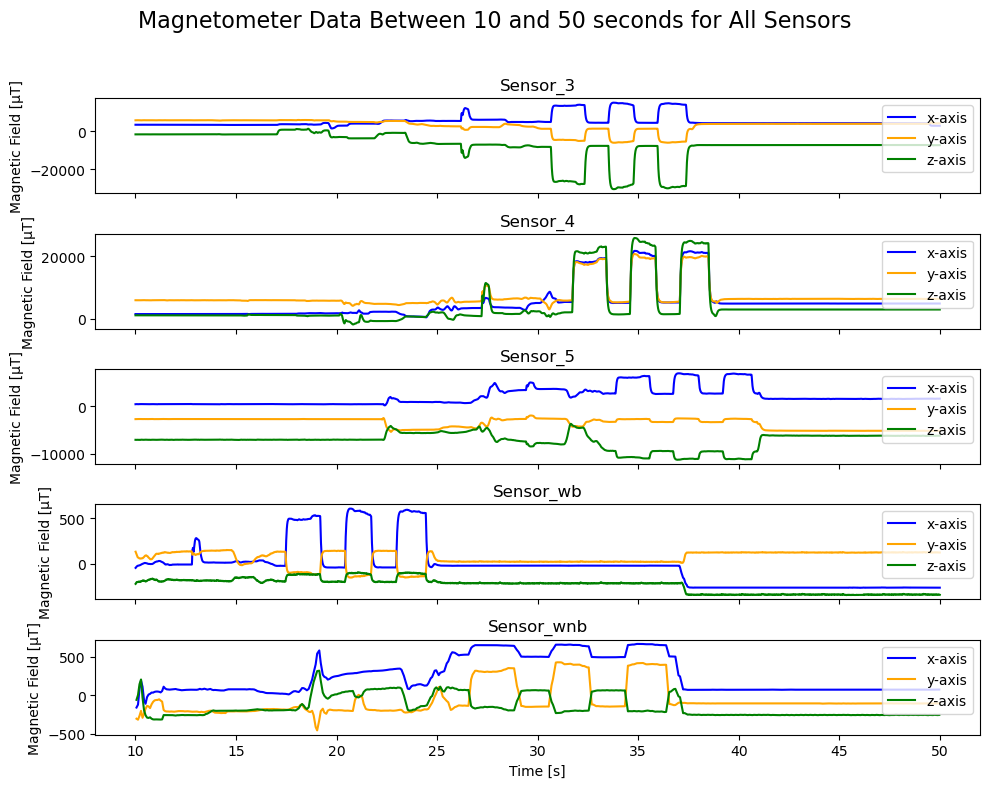

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Base directory where your IMU sensor data is stored
BASE_DIR = "IMUS"

# List of sensors
sensors = ['Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_wb', 'Sensor_wnb']

# General function to plot magnetometer data between any two time points x and y for all sensors
def plot_magnetometer_between_x_and_y_for_all_sensors(sensors, x, y):
    fig, axs = plt.subplots(len(sensors), 1, figsize=(10, 8), sharex=True)  # Create subplots, one for each sensor
    fig.suptitle(f'Magnetometer Data Between {x} and {y} seconds for All Sensors', fontsize=16)
    
    for idx, sensor in enumerate(sensors):
        file_name = f"{sensor}_Magnetometer.csv"
        file_path = os.path.join(BASE_DIR, sensor, file_name)

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            # Filter the dataframe for the time between x and y seconds
            df_filtered = df[(df['t'] >= x) & (df['t'] <= y)]
            
            # Plot x, y, z magnetometer data in subplots
            axs[idx].plot(df_filtered['t'], df_filtered['x'], label='x-axis', color='blue')
            axs[idx].plot(df_filtered['t'], df_filtered['y'], label='y-axis', color='orange')
            axs[idx].plot(df_filtered['t'], df_filtered['z'], label='z-axis', color='green')
            
            axs[idx].set_title(f'{sensor}', fontsize=12)
            axs[idx].set_ylabel('Magnetic Field [µT]')
            axs[idx].legend(loc='upper right')

    axs[-1].set_xlabel('Time [s]')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title and labels
    plt.show()

# Specify the time range
x = 10  # Start time in seconds
y = 50  # End time in seconds

# Call the function to plot the data for all sensors between the specified times
plot_magnetometer_between_x_and_y_for_all_sensors(sensors, x, y)


In [1]:
# Read all mag data into a list
# Create derivative column for all data
# Plot derivative column for a single sensor
# Create data dictionary for all sensors
# Choose to look at z axis
# Input the t_locations and adjustement factors by trial and error
# Loop through each sensor and find the peaks in the range
# Plot the peaks and the locations on the original data
# Inspect for accuracy and asjust if needed
# Select a reference peak (sensor_3) and save the peak locations 
# Find the difference in peak locations between the reference and other sensors
# Plot the difference in peak locations for each sensor and verify they line up
# We will be using the first peak location as the datum point, not the average
# Plot zoomed in region and check it looks good
# Get the phone magnetometer data
# Plot the phone magnetometer data
# Calculate derivative
# Find peaks
# Plot peaks
# Find the 'Real time' of the first peak
# This is the true datum point
# Find the difference between the phone and the offsets for each sensor
# Calculate a 'time_from_sync' column for each sensor
# Apply this time_from_sync to each of the mag, gyro, angle, acc, and quat data
# Synchronise the gps data (this should be fine since we can calculate a time from sync column in the gps data from the time column in the gps data and the phone time of first peak)
# Split the data into experiments
# Create plots for each experiment

# Group the experiments into (priority 1a(1), 1a(2), 1b(1), 1d(1) then 1b(1) and 1d(2)) that are to be examined
# Plot individual, more involved plots with the data in specific experiments
# This is the analysis
# Run experiments in the sim on a few key expts
# Perform automated parameter sweeps of a few key variables to see how they stack up
# Discussion
# Writeup
# Consolidate for paper
# Write thesis


In [1]:
# Read all mag data into a list
import pandas as pd
import matplotlib.pyplot as plt

sensor_names = ['sensor_3', 'sensor_4', 'sensor_5', 'wb', 'wnb']


df_sensor_3_mag = pd.read_csv('IMUS\Sensor_3\sensor_3_Magnetometer.csv')
df_sensor_4_mag = pd.read_csv('IMUS\Sensor_4\sensor_4_Magnetometer.csv')
df_sensor_5_mag = pd.read_csv('IMUS\Sensor_5\sensor_5_Magnetometer.csv')
df_sensor_wb_mag = pd.read_csv('IMUS\Sensor_wb\sensor_wb_Magnetometer.csv')
df_sensor_wnb_mag = pd.read_csv('IMUS\Sensor_wnb\sensor_wnb_Magnetometer.csv')

# list of dataframes
df_list = [df_sensor_3_mag, df_sensor_4_mag, df_sensor_5_mag, df_sensor_wb_mag, df_sensor_wnb_mag]

Text(0.5, 1.0, 'X-axis Magnetic Field vs Time for all sensors not synchronised')

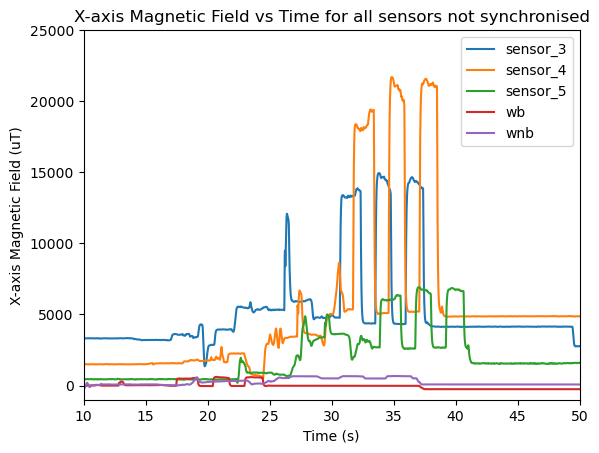

In [2]:
# Plot in the region of interest
# plot the magnetometer data against time

for i in range(len(df_list)):
    plt.plot(df_list[i]['t'], df_list[i]['x'], label = sensor_names[i])
plt.legend()
plt.xlim(10, 50)
plt.ylim(-1000, 25000)
plt.xlabel('Time (s)')
plt.ylabel('X-axis Magnetic Field (uT)')
plt.title('X-axis Magnetic Field vs Time for all sensors not synchronised')


In [3]:
# Create derivative column for all data
# Function to calculating derivative of a given column

def add_derivative_columns(df, time_col, value_cols):
    """
    Adds derivative columns to the DataFrame for specified value columns with respect to the time column.

    Parameters:
    - df: Pandas DataFrame containing the data.
    - time_col: String name of the time column in df.
    - value_cols: List of strings of the names of the columns to calculate the derivatives for.

    Returns:
    - Modified DataFrame with additional derivative columns.
    """
    for col in value_cols:
        derivative_col_name = f'd{col}/d{time_col}'
        df[derivative_col_name] = df[col].diff() / df[time_col].diff()
        df[derivative_col_name].fillna(0, inplace=True)
    
    return df

for df in df_list:
    df = add_derivative_columns(df, 't', ['x', 'y', 'z'])

Text(0.5, 1.0, 'Z-axis Magnetic Field Derivative vs Time for Sensor 3')

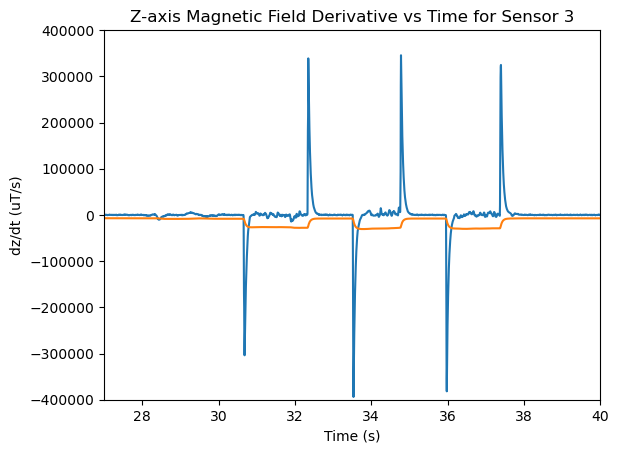

In [4]:
# Plot derivative column for a single sensor
plt.plot(df_sensor_3_mag['t'][1:], df_sensor_3_mag['dz/dt'][1:], label='dz/dt')
plt.plot(df_sensor_3_mag['t'], df_sensor_3_mag['z'], label='z')
plt.xlim(27, 40)
plt.ylim(-400000, 400000)
plt.xlabel('Time (s)')
plt.ylabel('dz/dt (uT/s)')
plt.title('Z-axis Magnetic Field Derivative vs Time for Sensor 3')

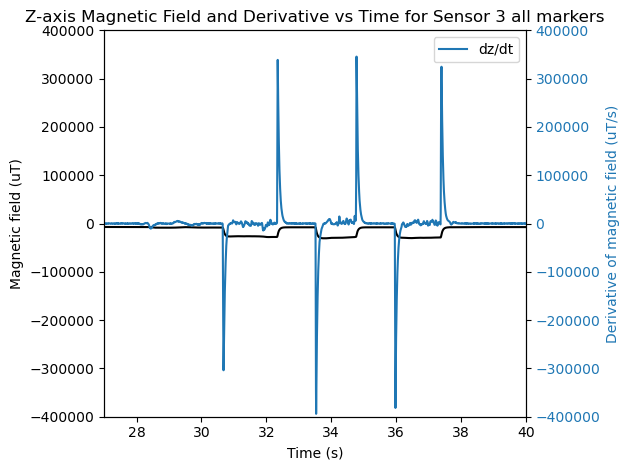

In [6]:
import matplotlib.pyplot as plt

# Create the first plot
fig, ax1 = plt.subplots()

# Plot the magnetic field 'z' on the left y-axis
color = 'black'  # Color for the first y-axis
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Magnetic field (uT)', color='black')
ax1.plot(df_sensor_3_mag['t'], df_sensor_3_mag['z'], label='z', color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(27, 40)
ax1.set_ylim(-400000, 400000)  # Set y-limits for 'dz/dt'
# ax1.set_ylim(bottom, top)  # Optional: if you want to manually set the y-limits for 'z'

# Create the second y-axis that shares the same x-axis
ax2 = ax1.twinx()  

# Plot the derivative of the magnetic field 'dz/dt' on the right y-axis
color = 'tab:blue'  # Color for the second y-axis
ax2.set_ylabel('Derivative of magnetic field (uT/s)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_sensor_3_mag['t'], df_sensor_3_mag['dz/dt'], label='dz/dt', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-400000, 400000)  # Set y-limits for 'dz/dt'

# Add a title and show the plot
plt.title('Z-axis Magnetic Field and Derivative vs Time for Sensor 3 all markers')
fig.tight_layout()  # Optional: adjust the layout to make room for the second y-label
plt.legend()
plt.show()


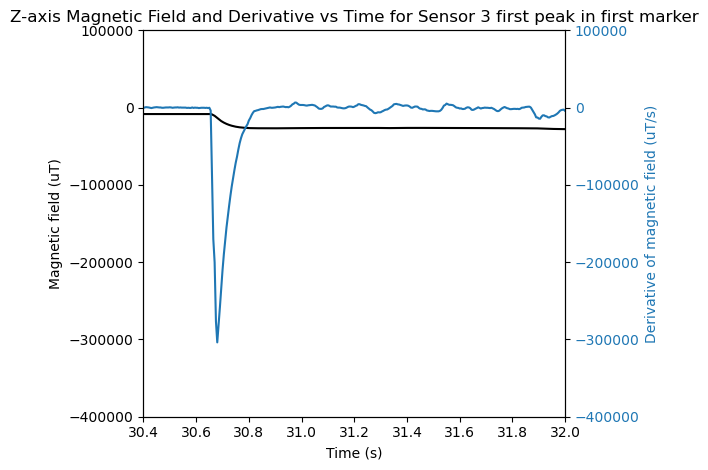

In [8]:
import matplotlib.pyplot as plt

# Assuming df_sensor_3_mag is your DataFrame with 't', 'dz/dt', and 'z' columns

# Create the first plot
fig, ax1 = plt.subplots()

# Plot the magnetic field 'z' on the left y-axis
color = 'black'  # Color for the first y-axis
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Magnetic field (uT)', color='black')
ax1.plot(df_sensor_3_mag['t'], df_sensor_3_mag['z'], label='z', color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim(30.4, 32)
ax1.set_ylim(-400000, 100000)  # Set y-limits for 'dz/dt'
# ax1.set_ylim(bottom, top)  # Optional: if you want to manually set the y-limits for 'z'

# Create the second y-axis that shares the same x-axis
ax2 = ax1.twinx()  

# Plot the derivative of the magnetic field 'dz/dt' on the right y-axis
color = 'tab:blue'  # Color for the second y-axis
ax2.set_ylabel('Derivative of magnetic field (uT/s)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_sensor_3_mag['t'], df_sensor_3_mag['dz/dt'], label='dz/dt', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-400000, 100000)  # Set y-limits for 'dz/dt'

# Add a title and show the plot
plt.title('Z-axis Magnetic Field and Derivative vs Time for Sensor 3 first peak in first marker')
fig.tight_layout()  # Optional: adjust the layout to make room for the second y-label
# plt.legend()
plt.show()


In [9]:
# Create data dictionary for all sensors
data_dictionary = [
    {'df_name': df_sensor_3_mag, 'sensor_name': '3', 't_locations': (27,40), 'peak_locations': [], 'df_shifted': df_sensor_3_mag.copy(), 'adjustment_factor_y_axis': 4000, 'adjustment_factor_height': 1},
    {'df_name': df_sensor_4_mag, 'sensor_name': '4', 't_locations': (31,40), 'peak_locations': [], 'df_shifted': df_sensor_4_mag.copy(), 'adjustment_factor_y_axis': 5000, 'adjustment_factor_height': 1},
    {'df_name': df_sensor_5_mag, 'sensor_name': '5', 't_locations': (33.5, 40.85), 'peak_locations': [], 'df_shifted': df_sensor_5_mag.copy(), 'adjustment_factor_y_axis': 2500, 'adjustment_factor_height': 1},
    {'df_name': df_sensor_wb_mag, 'sensor_name': 'wb', 't_locations': (16,25), 'peak_locations': [], 'df_shifted': df_sensor_wb_mag.copy(), 'adjustment_factor_y_axis': 0, 'adjustment_factor_height': 1},
    {'df_name': df_sensor_wnb_mag, 'sensor_name': 'wnb', 't_locations': (27,41), 'peak_locations': [], 'df_shifted': df_sensor_wnb_mag.copy(), 'adjustment_factor_y_axis': 0, 'adjustment_factor_height': 1}
]

(-10000.0, 10000.0)

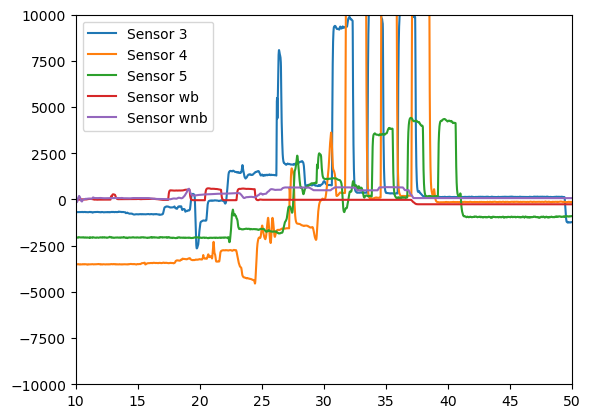

In [10]:
# plot the magnetometer data against time using adjusted y-axis and height
for data in data_dictionary:
    plt.plot(data['df_name']['t'], (data['df_name']['x']-data['adjustment_factor_y_axis'])*data['adjustment_factor_height'], label = f'Sensor {data["sensor_name"]}')
plt.legend()
plt.xlim(10, 50)
plt.ylim(-10000, 10000)


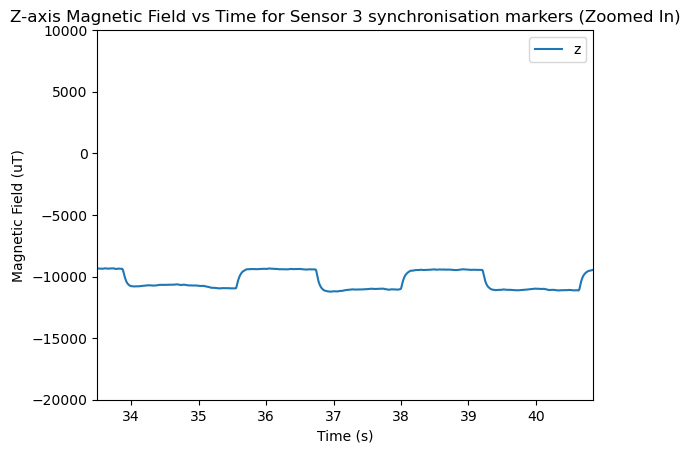

In [11]:
plt.plot(df_sensor_5_mag['t'], df_sensor_5_mag['z'], label='z')
# x limits
plt.xlim(33.5, 40.85)
plt.ylim(-20000, 10000)
plt.xlabel('Time (s)')
plt.ylabel('Magnetic Field (uT)')
plt.title('Z-axis Magnetic Field vs Time for Sensor 3 synchronisation markers (Zoomed In)')
plt.legend()
plt.show()


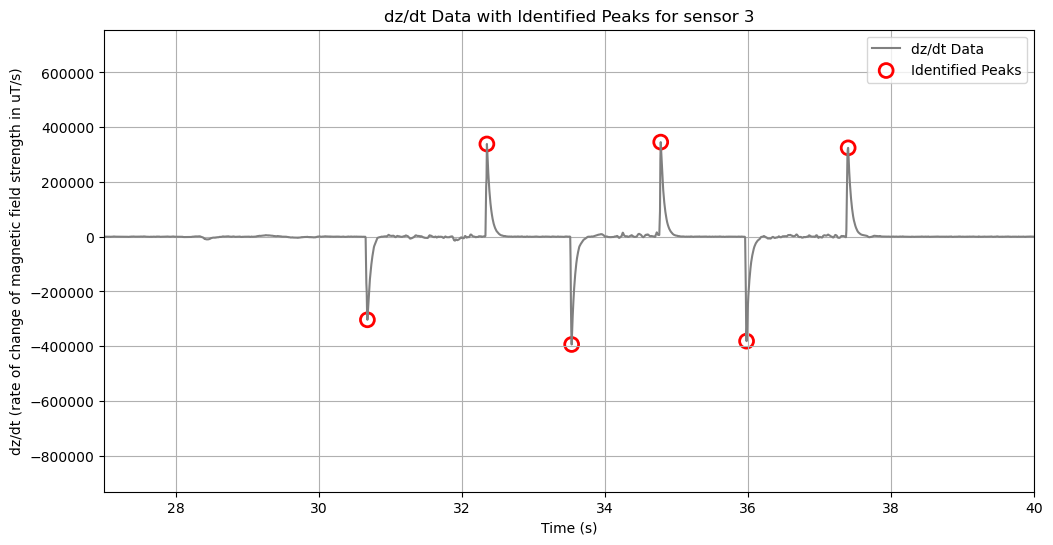

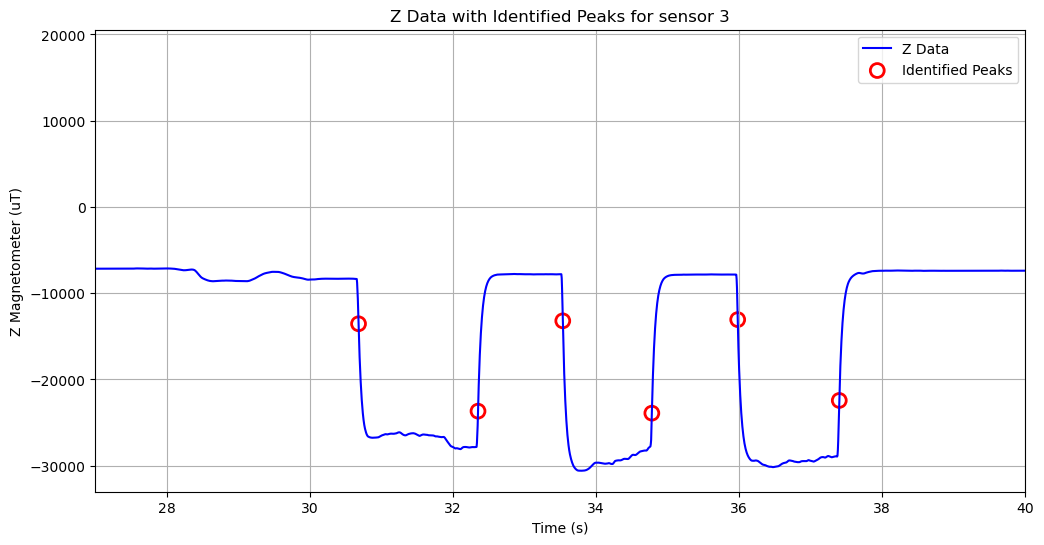

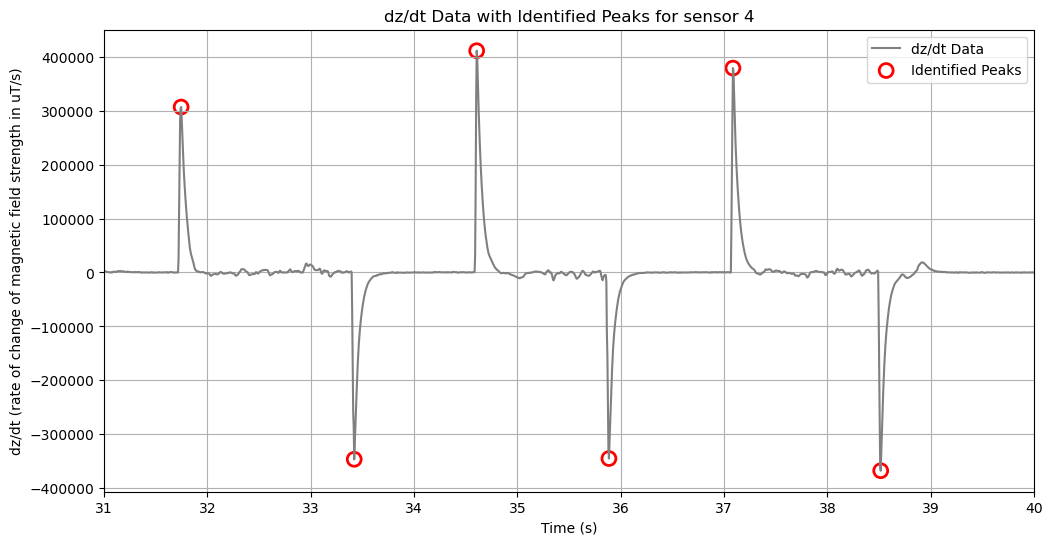

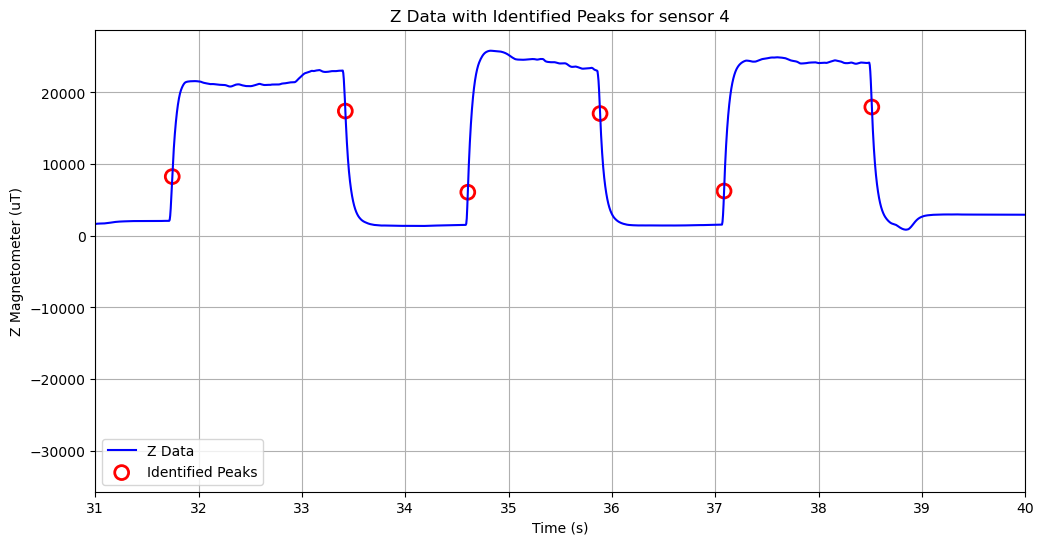

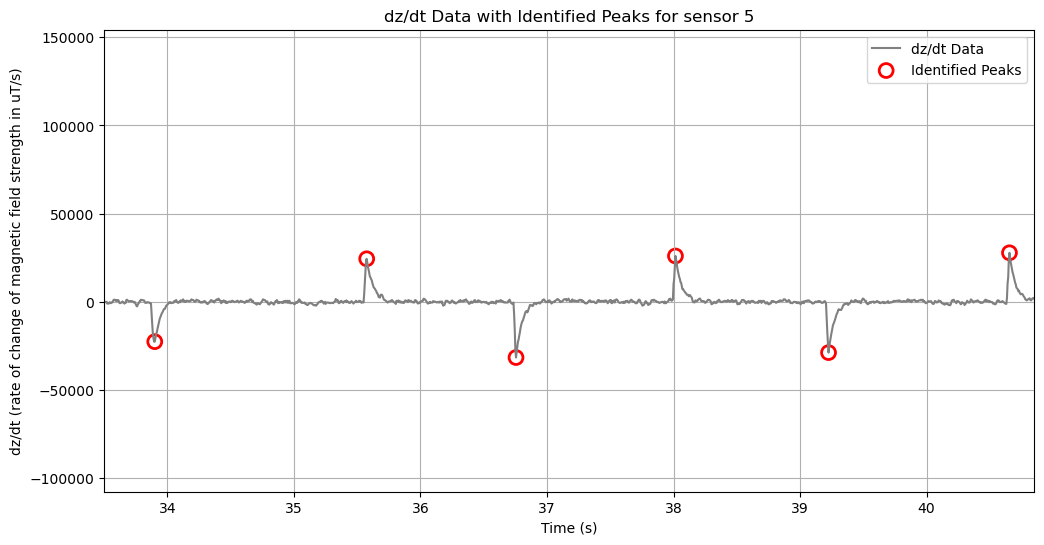

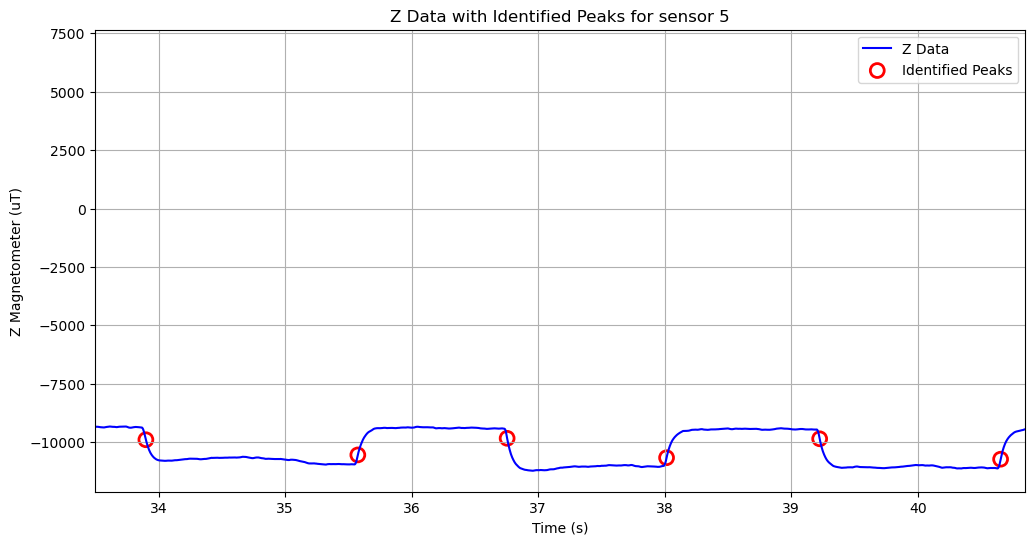

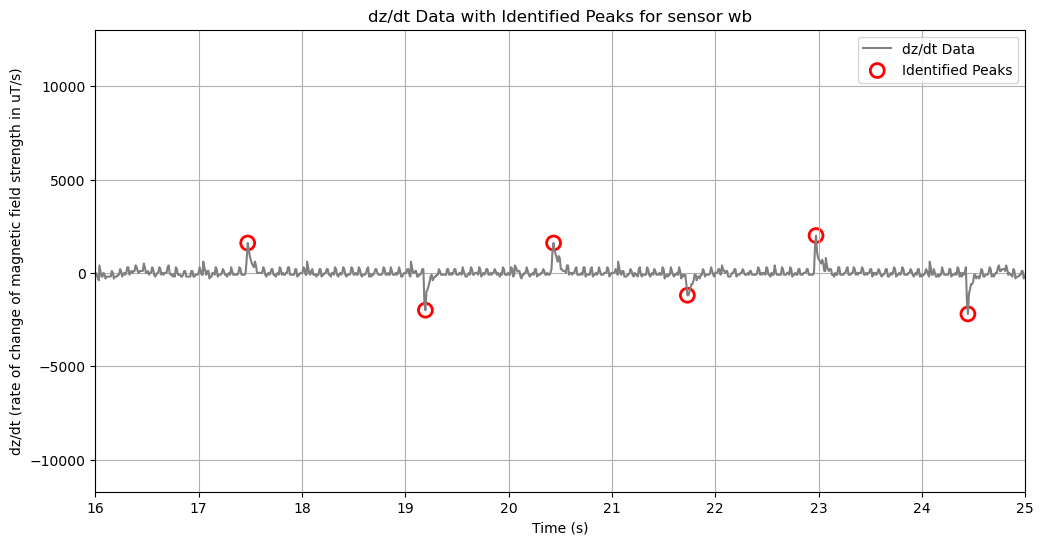

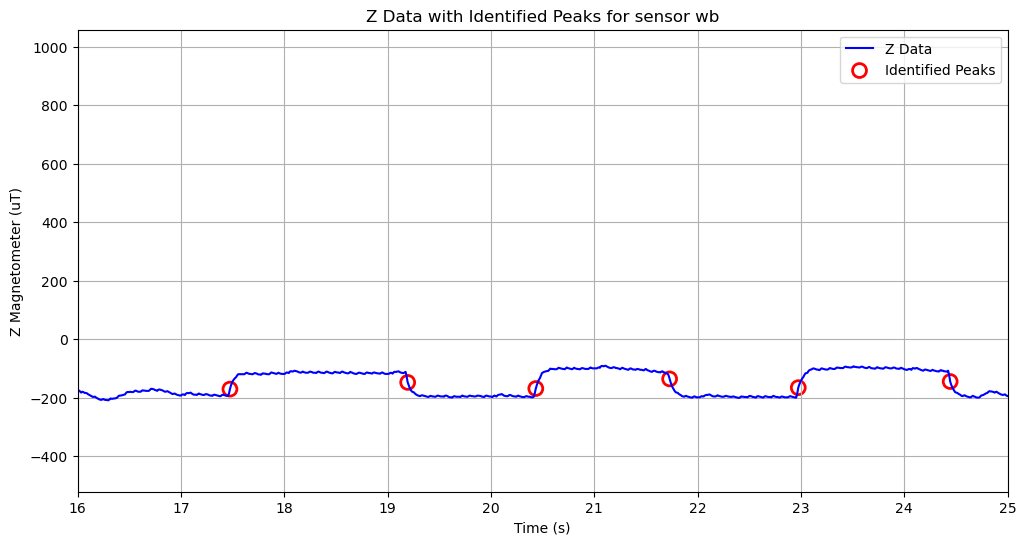

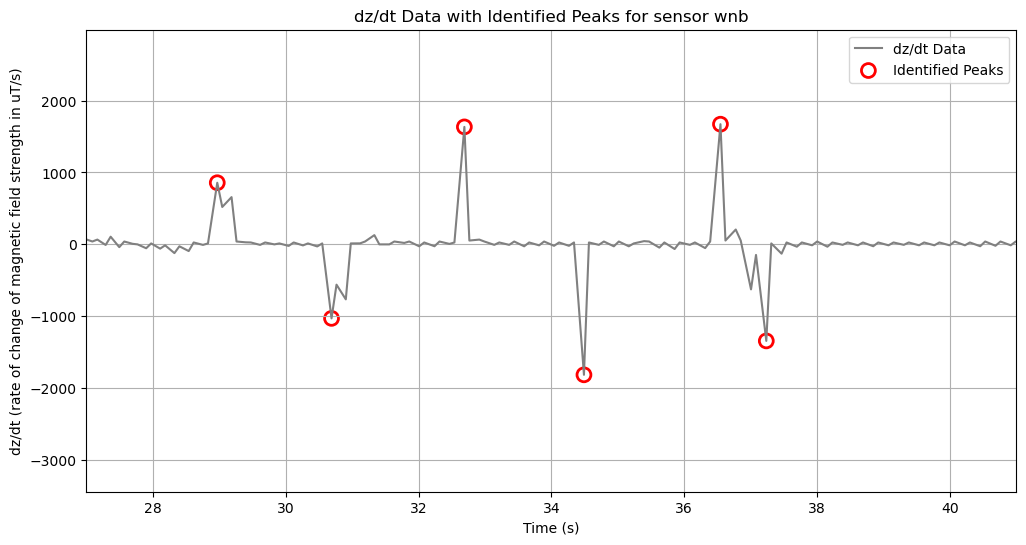

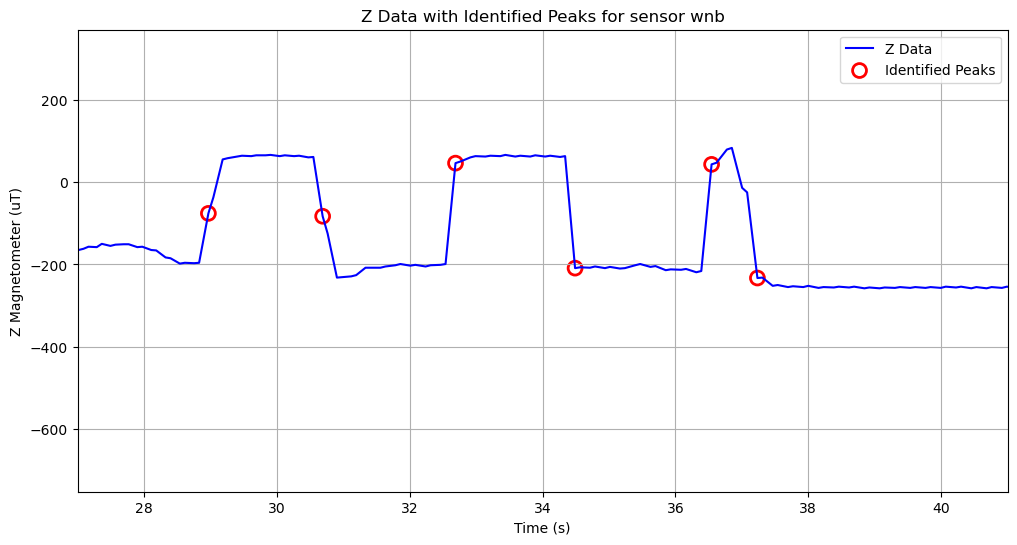

In [12]:
# Loop through each sensor and find the peaks in the range
import telemetry_utils as tu

# Loop through each entry in the data_dictionary

axis = 'z'
for entry in data_dictionary:
    # Extract the DataFrame and t_locations for the current entry
    df = entry['df_name']
    t1, t2 = entry['t_locations']
    num_peaks = 3


    # Call find_top_peaks_in_range for the current entry
    peak_locations = tu.find_top_peaks_in_range(df, axis, t1, t2, num_peaks=num_peaks)

    tu.plot_peaks_on_data(df, axis, peak_locations, entry['sensor_name'], xlim=(t1, t2))
    tu.plot_peaks_on_original_data(df, peak_locations, axis, entry['sensor_name'], xlim=(t1, t2))

    
    # Update the 'peak_locations' field with the result
    entry['peak_locations'] = peak_locations

In [13]:
# Select a reference peak (sensor_3) and save the peak locations 
reference_peaks = data_dictionary[0]['peak_locations']

for entry in data_dictionary:
    # Initialize a list to store differences
    differences = []
    
    # Compare each peak to the reference
    for i in range(len(reference_peaks)):
        # Calculate difference for the i-th peak, assuming all entries have at least as many peaks as the first
        if i < len(entry['peak_locations']):  # Check to avoid index out of range
            difference = entry['peak_locations'][i][0] - reference_peaks[i][0]
            differences.append(difference)
        else:
            # Handle case where there are fewer peaks than in the reference; decide on how to handle this
            differences.append(None)  # Placeholder; adjust as needed
    
    # Store the differences in the entry
    entry['peak_differences'] = differences


In [14]:
# Find the difference in peak locations between the reference and other sensors
print('Differences in peak locations relative to Sensor 3:')
for entry in data_dictionary:
    print(f'Sensor {entry["sensor_name"]}: {entry["peak_differences"]}')

Differences in peak locations relative to Sensor 3:
Sensor 3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Sensor 4: [1.0650000572204554, 1.0699999332427979, 1.0699999332427979, 1.1050000190734863, 1.1050000190734934, 1.1150000095367503]
Sensor 5: [3.2200000286102295, 3.2249999046325684, 3.2200000286102295, 3.2349998950958323, 3.245000123977661, 3.255000114440918]
Sensor wb: [-13.204999923706055, -13.154999971389767, -13.099999904632568, -13.049999952316284, -13.004999876022339, -12.954999923706051]
Sensor wnb: [-1.7099988937378718, -1.6599988460541617, -0.844998264312828, -0.28999834060675056, 0.5650017261504701, -0.1649984359741481]


In [15]:
# Plot the difference in peak locations for each sensor and verify they line up
for entry in data_dictionary:
    # Extract the list of peak differences
    peak_differences = entry['peak_differences']
    
    # Filter out None values from the list
    filtered_differences = [diff for diff in peak_differences if diff is not None]
    
    # Calculate the average of the peak differences, excluding None values
    average_difference = sum(filtered_differences) / len(filtered_differences) if filtered_differences else 0
    
    # Add the average difference to the dictionary
    entry['average_difference'] = average_difference

# Optionally, print to verify the results
for entry in data_dictionary:
    print(f"{entry['sensor_name']}: Average Difference = {entry['average_difference']}")


3: Average Difference = 0.0
4: Average Difference = 1.0883333285649635
5: Average Difference = 3.2333333492279066
wb: Average Difference = -13.078333258628845
wnb: Average Difference = -0.6841651757558816


In [16]:
for entry in data_dictionary:
    # Access the shifted dataframe
    df_shifted = entry['df_shifted']
    
    # Access the average difference value for this entry
    average_difference = entry['average_difference']
    
    # Shift the 't' column by the average difference
    df_shifted['t'] = df_shifted['t'] - average_difference
    
    # Update the entry with the shifted dataframe
    entry['df_shifted'] = df_shifted


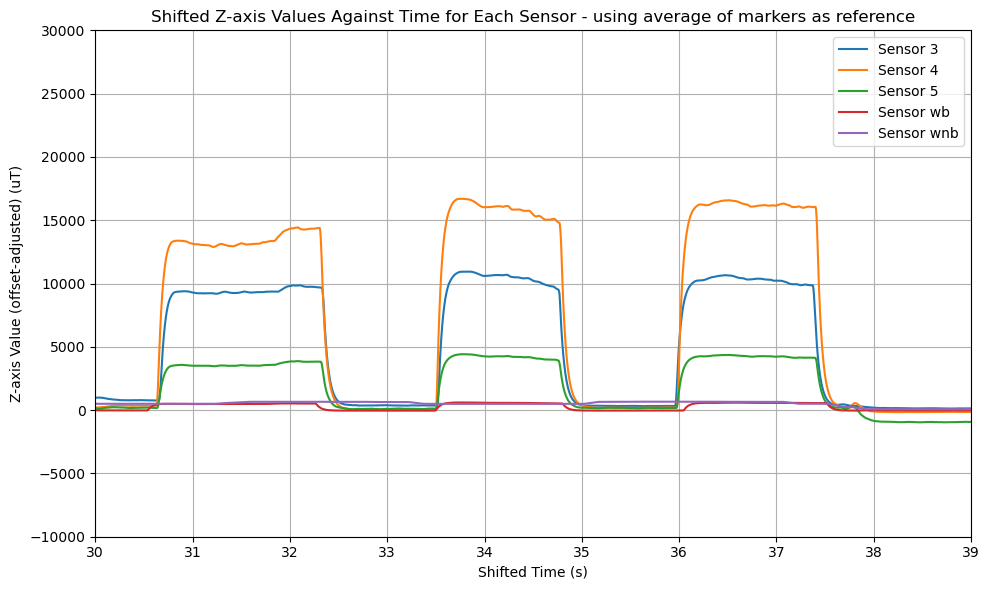

In [17]:
import matplotlib.pyplot as plt

# Prepare the plot
plt.figure(figsize=(10, 6))

# Loop through each entry in the data dictionary
for entry in data_dictionary:
    # Extract the shifted dataframe
    df_shifted = entry['df_shifted']
    
    # Plot 'z' against the shifted 't'
    plt.plot(df_shifted['t'], (df_shifted['x']-entry['adjustment_factor_y_axis'])*entry['adjustment_factor_height'], label = f'Sensor {entry["sensor_name"]}')
    
    # plt.plot(df_shifted['t'], df_shifted['z'], label=entry.get('sensor_name'))

# Configure plot settings
plt.xlabel('Shifted Time (s)')
plt.ylabel('Z-axis Value (offset-adjusted) (uT)')
plt.title('Shifted Z-axis Values Against Time for Each Sensor - using average of markers as reference')
plt.legend()  # Show legend to identify each line plot
plt.xlim(30, 39)  # Optional: Set x-axis limits to focus on the range of interest
plt.ylim(-10000,30000)
plt.grid(True)  # Optional: Adds a grid for easier visualization
plt.tight_layout()  # Adjust layout to make room for the legend

# Display the plot
plt.show()


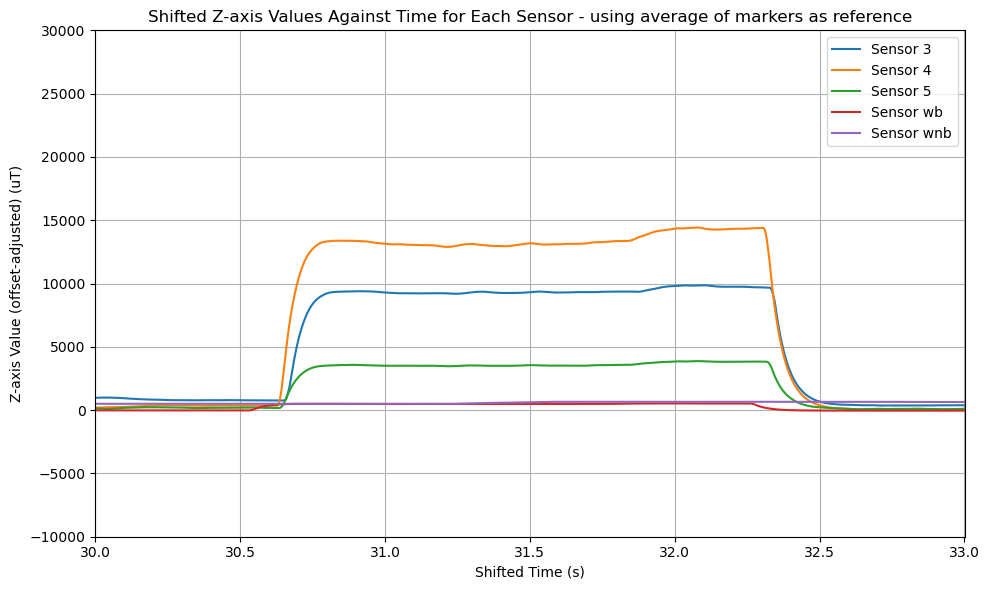

In [18]:
import matplotlib.pyplot as plt

# Prepare the plot
plt.figure(figsize=(10, 6))

# Loop through each entry in the data dictionary
for entry in data_dictionary:
    # Extract the shifted dataframe
    df_shifted = entry['df_shifted']
    
    # Plot 'z' against the shifted 't'
    plt.plot(df_shifted['t'], (df_shifted['x']-entry['adjustment_factor_y_axis'])*entry['adjustment_factor_height'], label = f'Sensor {entry["sensor_name"]}')
    
    # plt.plot(df_shifted['t'], df_shifted['z'], label=entry.get('sensor_name'))

# Configure plot settings
plt.xlabel('Shifted Time (s)')
plt.ylabel('Z-axis Value (offset-adjusted) (uT)')
plt.title('Shifted Z-axis Values Against Time for Each Sensor - using average of markers as reference')
plt.legend()  # Show legend to identify each line plot
plt.xlim(30, 33)  # Optional: Set x-axis limits to focus on the range of interest
plt.ylim(-10000,30000)
plt.grid(True)  # Optional: Adds a grid for easier visualization
plt.tight_layout()  # Adjust layout to make room for the legend

# Display the plot
plt.show()


In [19]:
# We will be using the first peak location as the datum point, not the average
for entry in data_dictionary:
    # Retrieve the first peak difference for the current sensor
    current_sensor_first_peak_time = entry['peak_locations'][0][0]
    print(f"Sensor {entry['sensor_name']}: First peak occurred at {current_sensor_first_peak_time} seconds")
    current_sensor_difference = entry['peak_differences'][0]
    # Calculate the 'time_from_sync' as the time from the reference sensor's first peak
    entry['df_shifted']['time_from_sync'] = entry['df_shifted']['t'] - current_sensor_first_peak_time + current_sensor_difference



Sensor 3: First peak occurred at 30.679999828338623 seconds
Sensor 4: First peak occurred at 31.74499988555908 seconds
Sensor 5: First peak occurred at 33.89999985694885 seconds
Sensor wb: First peak occurred at 17.47499990463257 seconds
Sensor wnb: First peak occurred at 28.97000093460075 seconds


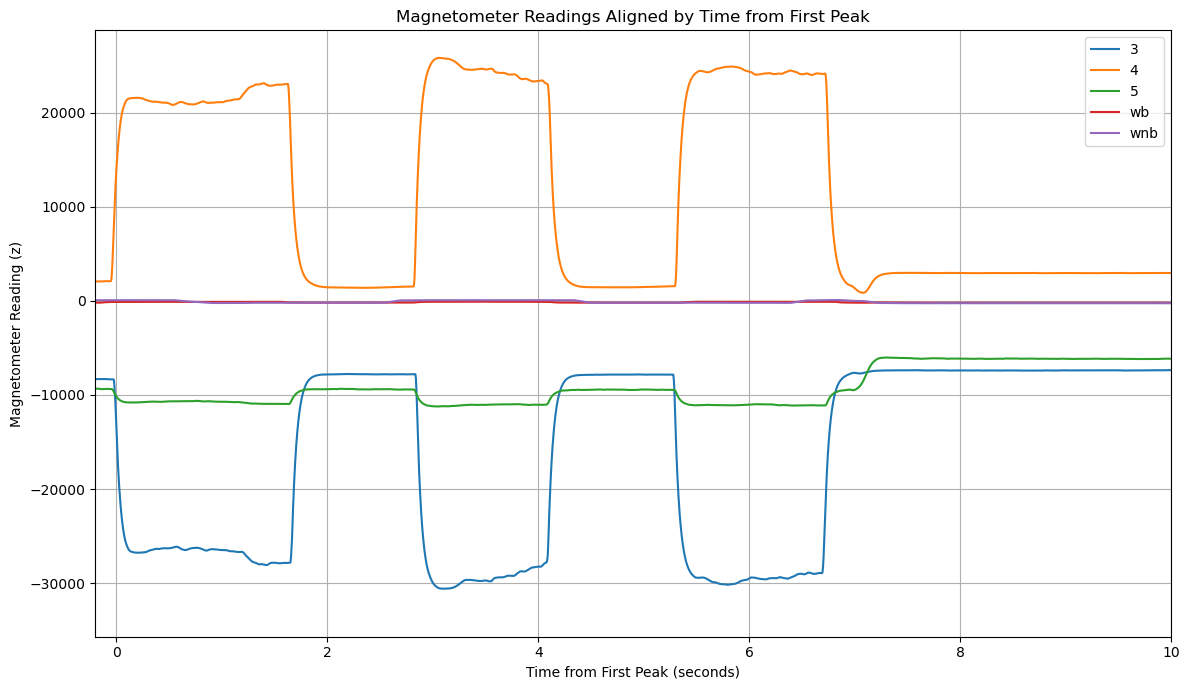

In [20]:
# Plot zoomed in region and check it looks good
import matplotlib.pyplot as plt

# Prepare the plot
plt.figure(figsize=(12, 7))

# Loop through each entry in the data dictionary and plot the data
for entry in data_dictionary:
    # Extract the DataFrame
    df_shifted = entry['df_shifted']
    
    # Make sure 'time_from_sync' exists
    if 'time_from_sync' in df_shifted.columns:
        plt.plot(df_shifted['time_from_sync'], df_shifted['z'], label=entry.get('sensor_name', 'Unknown'))

# Configure the plot settings
plt.xlabel('Time from First Peak (seconds)')
plt.ylabel('Magnetometer Reading (z)')
plt.title('Magnetometer Readings Aligned by Time from First Peak')
plt.xlim(-0.2, 10)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


In [21]:
# Get the phone magnetometer data
# Import necessary library
import pandas as pd

# Read in the phone magnetometer data from an Excel file
phone_magnetometer_df = pd.read_excel('../Phone Magnetometer/Magnetometer 2023-12-12 13-14-37.xls')

# Display the first few rows of the DataFrame
phone_magnetometer_df.head()


,t,x,y,z,abs
0,0.003344,28.080000,5.64,-35.759998,45.815647
1,0.013343,27.900000,5.40,-36.180000,46.006113
2,0.023341,27.660000,5.28,-36.779999,46.321942
3,0.033340,26.639999,5.58,-37.500000,46.336551
4,0.043339,25.980000,5.58,-37.799999,46.205375


Text(0.5, 1.0, 'Magnetic Field vs Time for Phone Magnetometer')

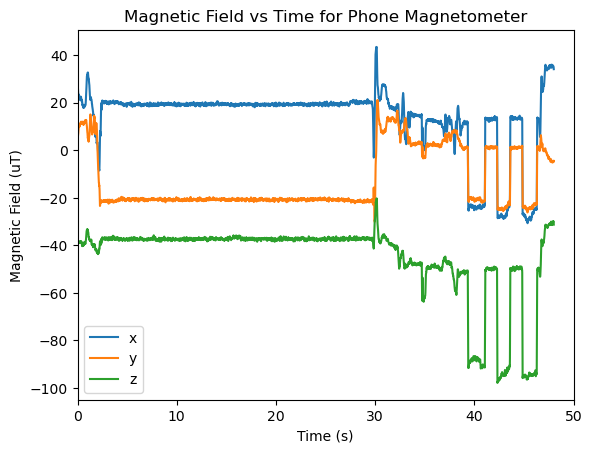

In [22]:
# Plot the phone magnetometer data
# plot the magnetometer data against time
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['x'], label='x')
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['y'], label='y')
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['z'], label='z')
plt.legend()
plt.xlim(0, 50)
# plt.ylim(-10000, 10000)
plt.xlabel('Time (s)')
plt.ylabel('Magnetic Field (uT)')
plt.title('Magnetic Field vs Time for Phone Magnetometer')


Text(0.5, 1.0, 'Magnetic Field vs Time for Phone Magnetometer')

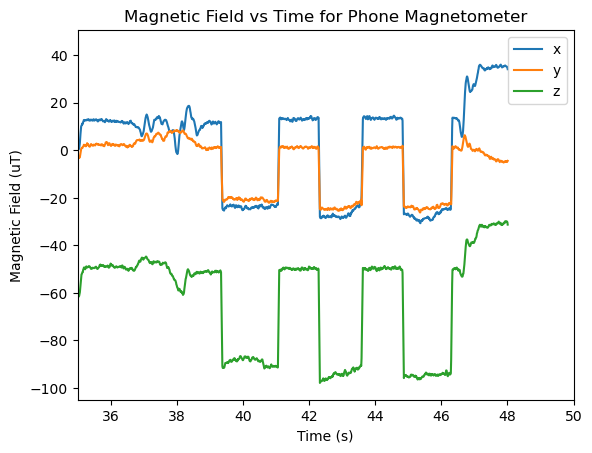

In [23]:
# Plot the phone magnetometer data
# plot the magnetometer data against time
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['x'], label='x')
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['y'], label='y')
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['z'], label='z')
plt.legend()
plt.xlim(35, 50)
# plt.ylim(-10000, 10000)
plt.xlabel('Time (s)')
plt.ylabel('Magnetic Field (uT)')
plt.title('Magnetic Field vs Time for Phone Magnetometer')


In [24]:
# Calculate derivative
phone_magnetometer_df = add_derivative_columns(phone_magnetometer_df, 't', ['x', 'y', 'z', 'abs'])

Text(0.5, 1.0, 'X-axis Magnetic Field Derivative vs Time for phone magnetometer')

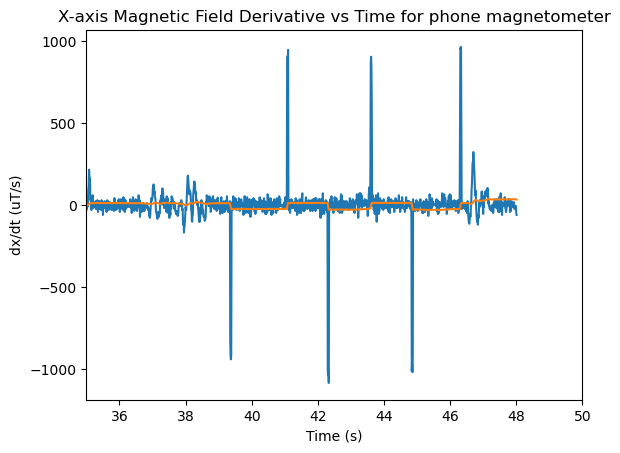

In [25]:
# Plot the derivative of the phone magnetometer data
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['dx/dt'], label='dz/dt')
plt.plot(phone_magnetometer_df['t'], phone_magnetometer_df['x'], label='z')
plt.xlim(35, 50)
# plt.ylim(-100000, 100000)
plt.xlabel('Time (s)')
plt.ylabel('dx/dt (uT/s)')
plt.title('X-axis Magnetic Field Derivative vs Time for phone magnetometer')

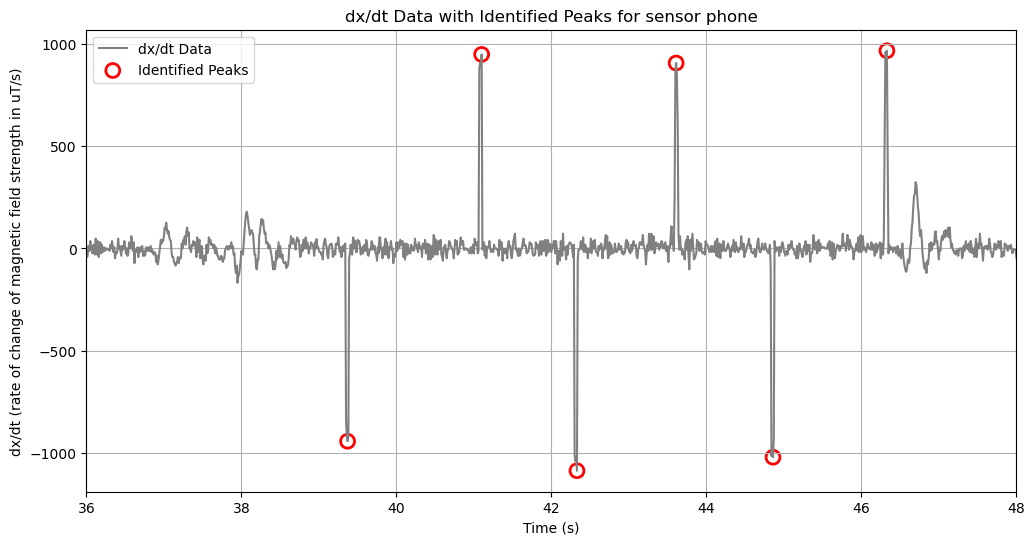

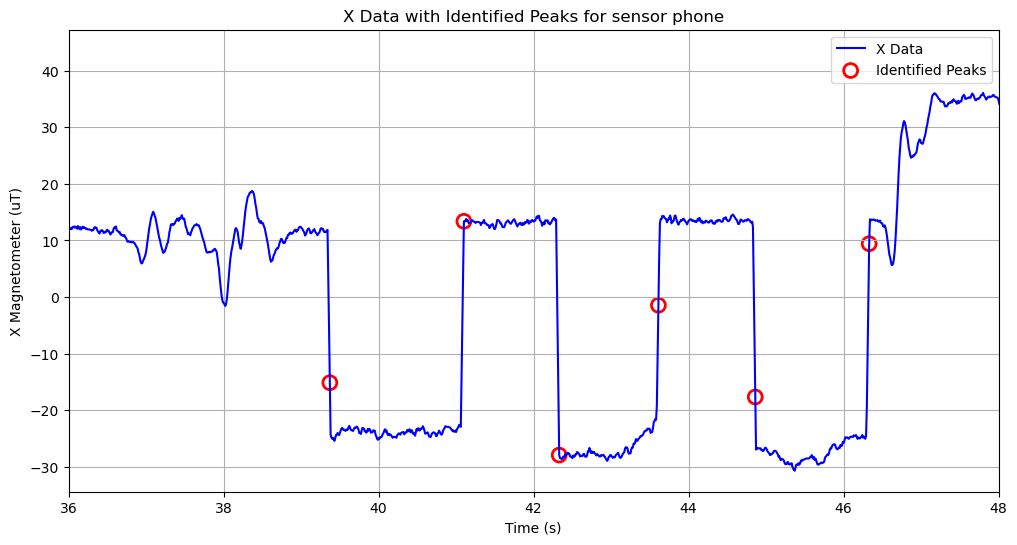

In [26]:
# Find peaks
# Call find_top_peaks_in_range for the current entry
t1, t2 = 36, 48
phone_peak_locations = tu.find_top_peaks_in_range(phone_magnetometer_df, 'x', t1, t2)

tu.plot_peaks_on_data(phone_magnetometer_df, 'x', phone_peak_locations, 'phone', xlim=(t1, t2))
tu.plot_peaks_on_original_data(phone_magnetometer_df, phone_peak_locations, 'x', 'phone', xlim=(t1, t2))

In [27]:
# Plot peaks

# Find location of the first peak
phone_peak_locations[0]


(39.370138578, -942.1193741537877)

In [28]:
# Read in phone metadata

# Import necessary library
import pandas as pd

# Read in the "Metadata Time" sheet from the Excel file
file_path = '../Phone Magnetometer/Magnetometer 2023-12-12 13-14-37.xls'  # Correct file path here

# Specify the sheet you want to read, in this case "Metadata Time"
metadata_time_df = pd.read_excel(file_path, sheet_name='Metadata Time')

# Display the first few rows of the DataFrame
metadata_time_df.head()


,event,experiment time,system time,system time text
0,START,0.000000,1.702387e+09,2023-12-12 13:13:46.452 UTCZ
1,PAUSE,48.015858,1.702387e+09,2023-12-12 13:14:34.468 UTCZ


In [29]:
from datetime import datetime, timedelta

# Step 1: Parse the string to a datetime object
# strip the last 4 characters from the string
dt_str = metadata_time_df['system time text'][0][:-5]
dt_format = "%Y-%m-%d %H:%M:%S.%f"
dt_obj = datetime.strptime(dt_str, dt_format)

# Step 2: Create a timedelta object for 22.5 seconds
delta = timedelta(seconds=phone_peak_locations[0][0])

# Step 3: Add the timedelta to the datetime object
offset_time = dt_obj + delta

# Step 4: Convert the new datetime object back to a string
offset_str = offset_time.strftime(dt_format)
offset_str


'2023-12-12 13:14:25.822139'

In [30]:
# Find the difference between the phone and the offsets for each sensor
print(f"Recording of phone magnetometer data began at {metadata_time_df['system time text'][0]}")
print(f"The first peak in the x-axis derivative data was detected at {phone_peak_locations[0][0]} seconds")
print(f"Therefore, the first peak in the x-axis derivative data occurred {offset_str}")

print("To calibrate the phone GPS, we will find the location of the closest GPS timestamp to the time calculated here. (122 later)")

Recording of phone magnetometer data began at 2023-12-12 13:13:46.452 UTCZ
The first peak in the x-axis derivative data was detected at 39.370138578 seconds
Therefore, the first peak in the x-axis derivative data occurred 2023-12-12 13:14:25.822139
To calibrate the phone GPS, we will find the location of the closest GPS timestamp to the time calculated here. (122 later)


In [31]:
# Calculate a 'time_from_sync' column for each sensor
# Read in all of the Accel, Angle, Gyro, Mag, and Quat data for each sensor
df_sensor_3_accel = pd.read_csv('IMUS\Sensor_3\sensor_3_Accelerometer.csv')
df_sensor_3_angle = pd.read_csv('IMUS\Sensor_3\sensor_3_Angle.csv')
df_sensor_3_gyro = pd.read_csv('IMUS\Sensor_3\sensor_3_Gyroscope.csv')
df_sensor_3_mag = pd.read_csv('IMUS\Sensor_3\sensor_3_Magnetometer.csv')
df_sensor_3_quat = pd.read_csv('IMUS\Sensor_3\sensor_3_Quaternion.csv')
df_sensor_4_accel = pd.read_csv('IMUS\Sensor_4\sensor_4_Accelerometer.csv')
df_sensor_4_angle = pd.read_csv('IMUS\Sensor_4\sensor_4_Angle.csv')
df_sensor_4_gyro = pd.read_csv('IMUS\Sensor_4\sensor_4_Gyroscope.csv')
df_sensor_4_mag = pd.read_csv('IMUS\Sensor_4\sensor_4_Magnetometer.csv')
df_sensor_4_quat = pd.read_csv('IMUS\Sensor_4\sensor_4_Quaternion.csv')
df_sensor_5_accel = pd.read_csv('IMUS\Sensor_5\sensor_5_Accelerometer.csv')
df_sensor_5_angle = pd.read_csv('IMUS\Sensor_5\sensor_5_Angle.csv')
df_sensor_5_gyro = pd.read_csv('IMUS\Sensor_5\sensor_5_Gyroscope.csv')
df_sensor_5_mag = pd.read_csv('IMUS\Sensor_5\sensor_5_Magnetometer.csv')
df_sensor_5_quat = pd.read_csv('IMUS\Sensor_5\sensor_5_Quaternion.csv')
df_sensor_wb_accel = pd.read_csv('IMUS\Sensor_wb\sensor_wb_Accelerometer.csv')
df_sensor_wb_angle = pd.read_csv('IMUS\Sensor_wb\sensor_wb_Angle.csv')
df_sensor_wb_gyro = pd.read_csv('IMUS\Sensor_wb\sensor_wb_Gyroscope.csv')
df_sensor_wb_mag = pd.read_csv('IMUS\Sensor_wb\sensor_wb_Magnetometer.csv')
df_sensor_wb_quat = pd.read_csv('IMUS\Sensor_wb\sensor_wb_Quaternion.csv')
df_sensor_wnb_accel = pd.read_csv('IMUS\Sensor_wnb\sensor_wnb_Accelerometer.csv')
df_sensor_wnb_angle = pd.read_csv('IMUS\Sensor_wnb\sensor_wnb_Angle.csv')
df_sensor_wnb_gyro = pd.read_csv('IMUS\Sensor_wnb\sensor_wnb_Gyroscope.csv')
df_sensor_wnb_mag = pd.read_csv('IMUS\Sensor_wnb\sensor_wnb_Magnetometer.csv')
df_sensor_wnb_quat = pd.read_csv('IMUS\Sensor_wnb\sensor_wnb_Quaternion.csv')


In [32]:
# Apply this time_from_sync to each of the mag, gyro, angle, acc, and quat data
# Iterate over your data_dictionary to add the 'time_from_sync' column from df_shifted to each DataFrame related to the sensor
for item in data_dictionary:
    # Extract the sensor_name for identifying the relevant DataFrames
    sensor_name = item['sensor_name']
    # Extract the 'time_from_sync' column from df_shifted
    time_from_sync_column = item['df_shifted']['time_from_sync']
    
    # Now, we find and assign this column to all related sensor DataFrames
    # For simplicity, let's manually map each sensor_name to its related DataFrames
    if sensor_name == '3':
        df_sensor_3_accel['time_from_sync'] = time_from_sync_column
        df_sensor_3_angle['time_from_sync'] = time_from_sync_column
        df_sensor_3_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_3_mag['time_from_sync'] = time_from_sync_column
        df_sensor_3_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == '4':
        df_sensor_4_accel['time_from_sync'] = time_from_sync_column
        df_sensor_4_angle['time_from_sync'] = time_from_sync_column
        df_sensor_4_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_4_mag['time_from_sync'] = time_from_sync_column
        df_sensor_4_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == '5':
        df_sensor_5_accel['time_from_sync'] = time_from_sync_column
        df_sensor_5_angle['time_from_sync'] = time_from_sync_column
        df_sensor_5_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_5_mag['time_from_sync'] = time_from_sync_column
        df_sensor_5_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == 'wb':
        df_sensor_wb_accel['time_from_sync'] = time_from_sync_column
        df_sensor_wb_angle['time_from_sync'] = time_from_sync_column
        df_sensor_wb_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_wb_mag['time_from_sync'] = time_from_sync_column
        df_sensor_wb_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == 'wnb':
        df_sensor_wnb_accel['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_angle['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_mag['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_quat['time_from_sync'] = time_from_sync_column


In [33]:
# collect into a list
all_imu_dfs = [df_sensor_3_accel, df_sensor_3_angle, df_sensor_3_gyro, df_sensor_3_mag, df_sensor_3_quat, df_sensor_4_accel, df_sensor_4_angle, df_sensor_4_gyro, df_sensor_4_mag, df_sensor_4_quat, df_sensor_5_accel, df_sensor_5_angle, df_sensor_5_gyro, df_sensor_5_mag, df_sensor_5_quat, df_sensor_wb_accel, df_sensor_wb_angle, df_sensor_wb_gyro, df_sensor_wb_mag, df_sensor_wb_quat, df_sensor_wnb_accel, df_sensor_wnb_angle, df_sensor_wnb_gyro, df_sensor_wnb_mag, df_sensor_wnb_quat]

Text(0.5, 1.0, 'X-axis Magnetic Field vs Time for all sensors synchronised')

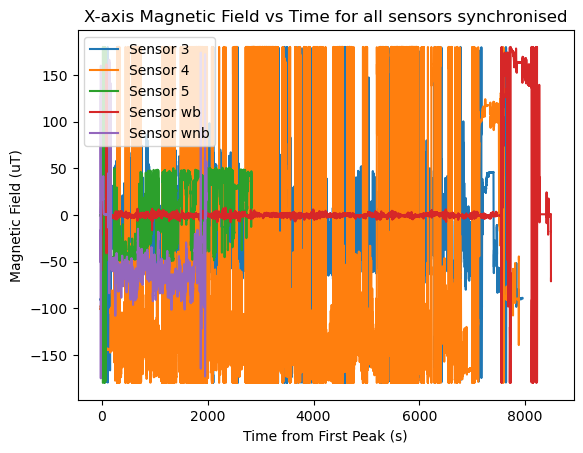

In [34]:
# Plot the magnetometer data against time for all sensors
plt.plot(df_sensor_3_angle['time_from_sync'], df_sensor_3_angle['x'], label='Sensor 3')
plt.plot(df_sensor_4_angle['time_from_sync'], df_sensor_4_angle['x'], label='Sensor 4')
plt.plot(df_sensor_5_angle['time_from_sync'], df_sensor_5_angle['x'], label='Sensor 5')
plt.plot(df_sensor_wb_angle['time_from_sync'], df_sensor_wb_angle['x'], label='Sensor wb')
plt.plot(df_sensor_wnb_angle['time_from_sync'], df_sensor_wnb_angle['x'], label='Sensor wnb')
plt.legend()
# plt.xlim(0, 1125)
# plt.ylim(-10000, 10000)
plt.xlabel('Time from First Peak (s)')
plt.ylabel('Magnetic Field (uT)')
plt.title('X-axis Magnetic Field vs Time for all sensors synchronised')


Text(0.5, 1.0, 'X-axis Magnetic Field vs Time for all sensors synchronised')

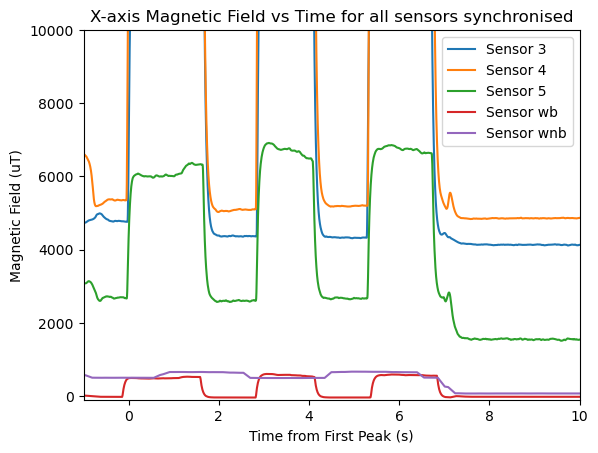

In [35]:
# Plot the magnetometer data against time for all sensors
plt.plot(df_sensor_3_mag['time_from_sync'], df_sensor_3_mag['x'], label='Sensor 3')
plt.plot(df_sensor_4_mag['time_from_sync'], df_sensor_4_mag['x'], label='Sensor 4')
plt.plot(df_sensor_5_mag['time_from_sync'], df_sensor_5_mag['x'], label='Sensor 5')
plt.plot(df_sensor_wb_mag['time_from_sync'], df_sensor_wb_mag['x'], label='Sensor wb')
plt.plot(df_sensor_wnb_mag['time_from_sync'], df_sensor_wnb_mag['x'], label='Sensor wnb')
plt.legend()
plt.xlim(-1, 10)
plt.ylim(-100, 10000)
plt.xlabel('Time from First Peak (s)')
plt.ylabel('Magnetic Field (uT)')
plt.title('X-axis Magnetic Field vs Time for all sensors synchronised')


Text(0.5, 1.0, 'X-axis Acceleration vs Time for all sensors synchronised')

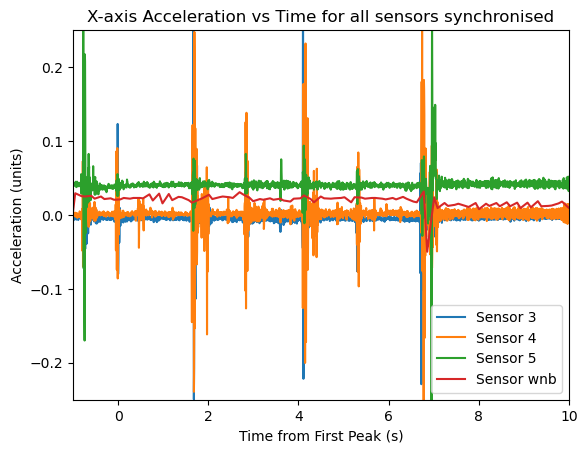

In [36]:
plt.plot(df_sensor_3_accel['time_from_sync'], df_sensor_3_accel['x'], label='Sensor 3')
plt.plot(df_sensor_4_accel['time_from_sync'], df_sensor_4_accel['x'], label='Sensor 4')
plt.plot(df_sensor_5_accel['time_from_sync'], df_sensor_5_accel['x'], label='Sensor 5')
plt.plot(df_sensor_wnb_accel['time_from_sync'], df_sensor_wnb_accel['x'], label='Sensor wnb')
plt.legend()
plt.xlim(-1, 10)
plt.ylim(-0.25, 0.25)
plt.xlabel('Time from First Peak (s)')
plt.ylabel('Acceleration (units)')
plt.title('X-axis Acceleration vs Time for all sensors synchronised')

Text(0.5, 1.0, 'Angle vs Time for Sensor 3, shifted and original')

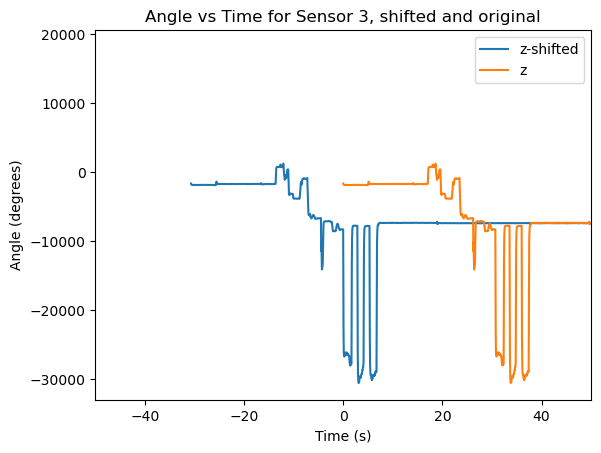

In [37]:
# Plot the Angle data with respect to time (t)
plt.plot(data_dictionary[0]['df_shifted']['time_from_sync'], df_sensor_3_mag['z'], label='z-shifted')
plt.plot(df_sensor_3_mag['t'], df_sensor_3_mag['z'], label='z')
plt.legend()
plt.xlim(-50, 50)
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Angle vs Time for Sensor 3, shifted and original')


Text(0.5, 1.0, 'Angle vs Time for Sensor 4, shifted and original')

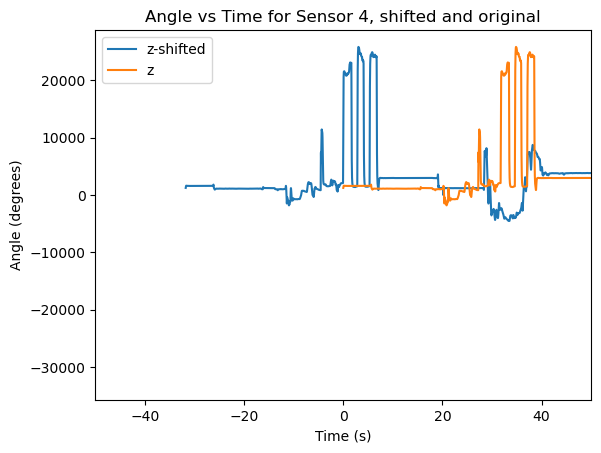

In [38]:
# Plot the Angle data with respect to time (t)
plt.plot(data_dictionary[1]['df_shifted']['time_from_sync'], df_sensor_4_mag['z'], label='z-shifted')
plt.plot(df_sensor_4_mag['t'], df_sensor_4_mag['z'], label='z')
plt.legend()
plt.xlim(-50, 50)
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Angle vs Time for Sensor 4, shifted and original')


In [39]:
# Create plots for each experiment
experiments = [
    {"name": "001_Synchronisation", "start": -121, "end": 9},
    {"name": "002_Setup", "start": 9, "end": 95},
    {"name": "003_Waiting_for_departure", "start": 95, "end": 282},
    {"name": "004_Seaway_departure", "start": 282, "end": 300},
    {"name": "005_Departure", "start": 300, "end": 590},
    {"name": "006_Departure_cruise", "start": 590, "end": 790},
    {"name": "007_Fast_stbd_turn_1", "start": 790, "end": 920},
    {"name": "008_Interesting_roll_angle", "start": 920, "end": 995},
    {"name": "009_Fast_port_turn_1", "start": 995, "end": 1125},
    {"name": "010_Waiting_for_static_turns", "start": 1125, "end": 1255},
    {"name": "011_Static_stbd_1", "start": 1255, "end": 1310},
    {"name": "012_Static_port_1", "start": 1310, "end": 1390},
    {"name": "013_Static_port_2", "start": 1382, "end": 1450},
    {"name": "014_Static_stbd_2", "start": 1430, "end": 1500},
    {"name": "015_Intermediate_travel", "start": 1525, "end": 1550},
    {"name": "016_Straight_cruise_1", "start": 1550, "end": 1638},
    {"name": "017_Slight_turn_1", "start": 1638, "end": 1715},
    {"name": "018_Straight_cruise_2", "start": 1715, "end": 1824},
    {"name": "019_Turn_stbd_1", "start": 1824, "end": 1930},
    {"name": "020_Straight_cruise_3", "start": 1930, "end": 2140},
    {"name": "021_Quarter_turn_port", "start": 2140, "end": 2185},
    {"name": "022_Quarter_turn_stbd", "start": 2185, "end": 2290},
    {"name": "023_Eigth_turn_port", "start": 2290, "end": 2440},
    {"name": "024_Eigth_turn_stbd", "start": 2440, "end": 2530},
    {"name": "025_Tavel_to_sweep", "start": 2530, "end": 2695},
    {"name": "026_Engine_rpm_sweep", "start": 2695, "end": 2820},
    {"name": "027_Interim", "start": 2820, "end": 2885},
    {"name": "028_Return_to_ryde", "start": 2885, "end": 7505},
    {"name": "029_Engine_off_clean_up", "start": 7505, "end": 8374},
    {"name": "030_Post_flight_sync", "start": 8374, "end": 8495}
]

In [41]:
import os
import pandas as pd

# List of sensors and data types
sensors = ['3', '4', '5', 'wb', 'wnb']
data_types = ['accel', 'angle', 'gyro', 'mag', 'quat']

# Create base directory structure
base_path = 'Experiments'
if not os.path.exists(base_path):
    os.makedirs(base_path)

# Function to create directory structure for an experiment
def create_exp_dirs(exp_name):
    exp_path = os.path.join(base_path, exp_name)
    if not os.path.exists(exp_path):
        os.makedirs(exp_path)
        os.makedirs(os.path.join(exp_path, 'GPS'))
        imu_path = os.path.join(exp_path, 'IMU')
        os.makedirs(imu_path)
        for sensor in sensors:
            os.makedirs(os.path.join(imu_path, f'Sensor_{sensor}'))

# Process each experiment
for exp in experiments:
    exp_name = exp['name']
    start_time = exp['start']
    end_time = exp['end']
    
    # Create directories
    create_exp_dirs(exp_name)
    
    # Process each sensor
    for sensor in sensors:
        for data_type in data_types:
            # Get corresponding dataframe
            df_name = f'df_sensor_{sensor}_{data_type}'
            df = locals()[df_name]
            
            # Filter data for this experiment's time range
            mask = (df['time_from_sync'] >= start_time) & (df['time_from_sync'] <= end_time)
            exp_df = df[mask]
            
            # Save to appropriate location
            output_path = os.path.join(base_path, 
                                     exp_name, 
                                     'IMU',
                                     f'Sensor_{sensor}',
                                     f'{data_type}_{exp_name}.csv')
            exp_df.to_csv(output_path, index=False)


In [ ]:
# Group the experiments into (priority 1a(1), 1a(2), 1b(1), 1d(1) then 1b(1) and 1d(2)) that are to be examined


In [ ]:
# Plot individual, more involved plots with the data in specific experiments


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# --------------------- GPS Data Processing ---------------------

# Read in GPS data
gps_csv_path = '2023-12-12_131207_2000Turns.csv'
gps_df = pd.read_csv(gps_csv_path)
print("Initial GPS Data:")
print(gps_df.head())

# Convert the "Time" column to datetime objects 
gps_df['Time'] = pd.to_datetime(gps_df['Time'], utc=True)

# Select the reference timestamp (e.g., the entry at index 121)
reference_index = 121
if reference_index >= len(gps_df):
    raise IndexError(f"Reference index {reference_index} is out of bounds for GPS data with length {len(gps_df)}.")
reference_timestamp = gps_df['Time'].iloc[reference_index]
print(f"Reference Timestamp: {reference_timestamp}")

# Calculate the time difference from the reference timestamp for each row
gps_df['time_from_sync'] = (gps_df['Time'] - reference_timestamp).dt.total_seconds()

# --------------------- Save Modified GPS Data ---------------------

# Define the output CSV file path
output_csv_path = 'afternoon_trials_with_time_from_sync.csv'

# Save the DataFrame to the new CSV file without the index
gps_df.to_csv(output_csv_path, index=False)

print(f"GPS data with 'time_from_sync' has been saved to '{output_csv_path}'.")


Initial GPS Data:
        Lat      Lng  Alt   Acc                      Time  Prv    OrgLat  \
0  50.73282 -1.15827    0  8.00  2023-12-12T13:12:24.000Z  gps  50.73282   
1  50.73282 -1.15827    0  8.00  2023-12-12T13:12:24.000Z  gps  50.73282   
2  50.73282 -1.15827   -1  5.84  2023-12-12T13:12:25.000Z  gps  50.73282   
3  50.73282 -1.15827   -1  5.08  2023-12-12T13:12:26.000Z  gps  50.73282   
4  50.73282 -1.15827    0  4.75  2023-12-12T13:12:27.000Z  gps  50.73282   

    OrgLng  OrgAlt  OrgAcc  ...  DGPSAge  DGPSStat Category    TimeWithTZ  \
0 -1.15827      48     8.0  ...        -         -     Ship  13:12:24 GMT   
1 -1.15827      48     8.0  ...        -         -     Ship  13:12:24 GMT   
2 -1.15827      48     8.0  ...        -         -     Ship  13:12:25 GMT   
3 -1.15827      48     8.0  ...        -         -     Ship  13:12:26 GMT   
4 -1.15828      48     8.0  ...        -         -     Ship  13:12:27 GMT   

     TimeWithMS    DeviceTime     WriteTime  SpeedKPH  SpeedMP

In [130]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# --------------------- GPS Data Processing ---------------------

# Read in GPS data
gps_csv_path = '2023-12-12_131207_2000Turns.csv'
gps_df = pd.read_csv(gps_csv_path)
print("Initial GPS Data:")
print(gps_df.head())

# Convert the "Time" column to datetime objects 
gps_df['Time'] = pd.to_datetime(gps_df['Time'], utc=True)

# Select the reference timestamp (e.g., the entry at index 121)
reference_index = 121
if reference_index >= len(gps_df):
    raise IndexError(f"Reference index {reference_index} is out of bounds for GPS data with length {len(gps_df)}.")
reference_timestamp = gps_df['Time'].iloc[reference_index]
print(f"Reference Timestamp: {reference_timestamp}")

# Calculate the time difference from the reference timestamp for each row
gps_df['time_from_sync'] = (gps_df['Time'] - reference_timestamp).dt.total_seconds()

print("GPS Data with 'time_from_sync':")
print(gps_df.head())

# Define experiments with start and end times
experiments = [
    {"name": "001_Synchronisation", "start": -121, "end": 9},
    {"name": "002_Setup", "start": 9, "end": 95},
    {"name": "003_Waiting_for_departure", "start": 95, "end": 282},
    {"name": "004_Seaway_departure", "start": 282, "end": 300},
    {"name": "005_Departure", "start": 300, "end": 590},
    {"name": "006_Departure_cruise", "start": 590, "end": 790},
    {"name": "007_Fast_stbd_turn_1", "start": 790, "end": 920},
    {"name": "008_Interesting_roll_angle", "start": 920, "end": 995},
    {"name": "009_Fast_port_turn_1", "start": 995, "end": 1125},
    {"name": "010_Waiting_for_static_turns", "start": 1125, "end": 1255},
    {"name": "011_Static_stbd_1", "start": 1255, "end": 1310},
    {"name": "012_Static_port_1", "start": 1310, "end": 1390},
    {"name": "013_Static_port_2", "start": 1382, "end": 1450},
    {"name": "014_Static_stbd_2", "start": 1430, "end": 1500},
    {"name": "015_Intermediate_travel", "start": 1525, "end": 1550},
    {"name": "016_Straight_cruise_1", "start": 1550, "end": 1638},
    {"name": "017_Slight_turn_1", "start": 1638, "end": 1715},
    {"name": "018_Straight_cruise_2", "start": 1715, "end": 1824},
    {"name": "019_Turn_stbd_1", "start": 1824, "end": 1930},
    {"name": "020_Straight_cruise_3", "start": 1930, "end": 2140},
    {"name": "021_Quarter_turn_port", "start": 2140, "end": 2185},
    {"name": "022_Quarter_turn_stbd", "start": 2185, "end": 2290},
    {"name": "023_Eigth_turn_port", "start": 2290, "end": 2440},
    {"name": "024_Eigth_turn_stbd", "start": 2440, "end": 2530},
    {"name": "025_Tavel_to_sweep", "start": 2530, "end": 2695},
    {"name": "026_Engine_rpm_sweep", "start": 2695, "end": 2820},
    {"name": "027_Interim", "start": 2820, "end": 2885},
    {"name": "028_Return_to_ryde", "start": 2885, "end": 7505},
    {"name": "029_Engine_off_clean_up", "start": 7505, "end": 8374},
    {"name": "030_Post_flight_sync", "start": 8374, "end": 8495}
]

# Save the GPS data into separate files for each experiment
for experiment in experiments:
    start_time = experiment['start']
    end_time = experiment['end']
    experiment_name = experiment['name']

    # Create GPS directory for the experiment
    gps_dir_path = os.path.join("Experiments", experiment_name, "GPS")
    os.makedirs(gps_dir_path, exist_ok=True)

    # Filter GPS data for the current experiment
    filtered_gps_df = gps_df[(gps_df['time_from_sync'] >= start_time) & (gps_df['time_from_sync'] < end_time)]

    # Save the filtered GPS data
    gps_file_name = f"GPS_{experiment_name}.csv"
    filtered_gps_df.to_csv(os.path.join(gps_dir_path, gps_file_name), index=False)

    print(f"Saved GPS data for {experiment_name} at {os.path.join(gps_dir_path, gps_file_name)}")

# --------------------- IMU Data Processing ---------------------

# Read in all of the Accel, Angle, Gyro, Mag, and Quat data for each sensor
# Note: Use raw strings or double backslashes to avoid issues with backslashes in file paths
df_sensor_3_accel = pd.read_csv(r'IMUS\Sensor_3\sensor_3_Accelerometer.csv')
df_sensor_3_angle = pd.read_csv(r'IMUS\Sensor_3\sensor_3_Angle.csv')
df_sensor_3_gyro = pd.read_csv(r'IMUS\Sensor_3\sensor_3_Gyroscope.csv')
df_sensor_3_mag = pd.read_csv(r'IMUS\Sensor_3\sensor_3_Magnetometer.csv')
df_sensor_3_quat = pd.read_csv(r'IMUS\Sensor_3\sensor_3_Quaternion.csv')

df_sensor_4_accel = pd.read_csv(r'IMUS\Sensor_4\sensor_4_Accelerometer.csv')
df_sensor_4_angle = pd.read_csv(r'IMUS\Sensor_4\sensor_4_Angle.csv')
df_sensor_4_gyro = pd.read_csv(r'IMUS\Sensor_4\sensor_4_Gyroscope.csv')
df_sensor_4_mag = pd.read_csv(r'IMUS\Sensor_4\sensor_4_Magnetometer.csv')
df_sensor_4_quat = pd.read_csv(r'IMUS\Sensor_4\sensor_4_Quaternion.csv')

df_sensor_5_accel = pd.read_csv(r'IMUS\Sensor_5\sensor_5_Accelerometer.csv')
df_sensor_5_angle = pd.read_csv(r'IMUS\Sensor_5\sensor_5_Angle.csv')
df_sensor_5_gyro = pd.read_csv(r'IMUS\Sensor_5\sensor_5_Gyroscope.csv')
df_sensor_5_mag = pd.read_csv(r'IMUS\Sensor_5\sensor_5_Magnetometer.csv')
df_sensor_5_quat = pd.read_csv(r'IMUS\Sensor_5\sensor_5_Quaternion.csv')

df_sensor_wb_accel = pd.read_csv(r'IMUS\Sensor_wb\sensor_wb_Accelerometer.csv')
df_sensor_wb_angle = pd.read_csv(r'IMUS\Sensor_wb\sensor_wb_Angle.csv')
df_sensor_wb_gyro = pd.read_csv(r'IMUS\Sensor_wb\sensor_wb_Gyroscope.csv')
df_sensor_wb_mag = pd.read_csv(r'IMUS\Sensor_wb\sensor_wb_Magnetometer.csv')
df_sensor_wb_quat = pd.read_csv(r'IMUS\Sensor_wb\sensor_wb_Quaternion.csv')

df_sensor_wnb_accel = pd.read_csv(r'IMUS\Sensor_wnb\sensor_wnb_Accelerometer.csv')
df_sensor_wnb_angle = pd.read_csv(r'IMUS\Sensor_wnb\sensor_wnb_Angle.csv')
df_sensor_wnb_gyro = pd.read_csv(r'IMUS\Sensor_wnb\sensor_wnb_Gyroscope.csv')
df_sensor_wnb_mag = pd.read_csv(r'IMUS\Sensor_wnb\sensor_wnb_Magnetometer.csv')
df_sensor_wnb_quat = pd.read_csv(r'IMUS\Sensor_wnb\sensor_wnb_Quaternion.csv')

# Create data dictionary for all sensors
data_dictionary = [
    {
        'df_name': df_sensor_3_mag,
        'sensor_name': '3',
        't_locations': (27, 40),
        'peak_locations': [],
        'df_shifted': df_sensor_3_mag.copy(),
        'adjustment_factor_y_axis': 4000,
        'adjustment_factor_height': 1
    },
    {
        'df_name': df_sensor_4_mag,
        'sensor_name': '4',
        't_locations': (31, 40),
        'peak_locations': [],
        'df_shifted': df_sensor_4_mag.copy(),
        'adjustment_factor_y_axis': 5000,
        'adjustment_factor_height': 1
    },
    {
        'df_name': df_sensor_5_mag,
        'sensor_name': '5',
        't_locations': (33.5, 40.85),
        'peak_locations': [],
        'df_shifted': df_sensor_5_mag.copy(),
        'adjustment_factor_y_axis': 2500,
        'adjustment_factor_height': 1
    },
    {
        'df_name': df_sensor_wb_mag,
        'sensor_name': 'wb',
        't_locations': (16, 25),
        'peak_locations': [],
        'df_shifted': df_sensor_wb_mag.copy(),
        'adjustment_factor_y_axis': 0,
        'adjustment_factor_height': 1
    },
    {
        'df_name': df_sensor_wnb_mag,
        'sensor_name': 'wnb',
        't_locations': (27, 41),
        'peak_locations': [],
        'df_shifted': df_sensor_wnb_mag.copy(),
        'adjustment_factor_y_axis': 0,
        'adjustment_factor_height': 1
    }
]

# Apply this time_from_sync to each of the mag, gyro, angle, acc, and quat data
# Iterate over your data_dictionary to add the 'time_from_sync' column from df_shifted to each DataFrame related to the sensor
for item in data_dictionary:
    # Extract the sensor_name for identifying the relevant DataFrames
    sensor_name = item['sensor_name']
    # Extract the 'time_from_sync' column from df_shifted
    time_from_sync_column = item['df_shifted']['time_from_sync']
    
    # Now, we find and assign this column to all related sensor DataFrames
    # For simplicity, let's manually map each sensor_name to its related DataFrames
    if sensor_name == '3':
        df_sensor_3_accel['time_from_sync'] = time_from_sync_column
        df_sensor_3_angle['time_from_sync'] = time_from_sync_column
        df_sensor_3_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_3_mag['time_from_sync'] = time_from_sync_column
        df_sensor_3_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == '4':
        df_sensor_4_accel['time_from_sync'] = time_from_sync_column
        df_sensor_4_angle['time_from_sync'] = time_from_sync_column
        df_sensor_4_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_4_mag['time_from_sync'] = time_from_sync_column
        df_sensor_4_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == '5':
        df_sensor_5_accel['time_from_sync'] = time_from_sync_column
        df_sensor_5_angle['time_from_sync'] = time_from_sync_column
        df_sensor_5_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_5_mag['time_from_sync'] = time_from_sync_column
        df_sensor_5_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == 'wb':
        df_sensor_wb_accel['time_from_sync'] = time_from_sync_column
        df_sensor_wb_angle['time_from_sync'] = time_from_sync_column
        df_sensor_wb_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_wb_mag['time_from_sync'] = time_from_sync_column
        df_sensor_wb_quat['time_from_sync'] = time_from_sync_column
    elif sensor_name == 'wnb':
        df_sensor_wnb_accel['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_angle['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_gyro['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_mag['time_from_sync'] = time_from_sync_column
        df_sensor_wnb_quat['time_from_sync'] = time_from_sync_column
    else:
        print(f"Warning: Unknown sensor name '{sensor_name}' in data_dictionary.")

# List all IMU DataFrames
all_imu_dfs = [
    df_sensor_3_accel, df_sensor_3_angle, df_sensor_3_gyro, df_sensor_3_mag, df_sensor_3_quat,
    df_sensor_4_accel, df_sensor_4_angle, df_sensor_4_gyro, df_sensor_4_mag, df_sensor_4_quat,
    df_sensor_5_accel, df_sensor_5_angle, df_sensor_5_gyro, df_sensor_5_mag, df_sensor_5_quat,
    df_sensor_wb_accel, df_sensor_wb_angle, df_sensor_wb_gyro, df_sensor_wb_mag, df_sensor_wb_quat,
    df_sensor_wnb_accel, df_sensor_wnb_angle, df_sensor_wnb_gyro, df_sensor_wnb_mag, df_sensor_wnb_quat
]

# Organize IMU DataFrames into a nested dictionary for easier access
sensors = ['3', '4', '5', 'wb', 'wnb']
data_types = ['accel', 'angle', 'gyro', 'mag', 'quat']

imu_data = {
    '3': {
        'accel': df_sensor_3_accel,
        'angle': df_sensor_3_angle,
        'gyro': df_sensor_3_gyro,
        'mag': df_sensor_3_mag,
        'quat': df_sensor_3_quat,
    },
    '4': {
        'accel': df_sensor_4_accel,
        'angle': df_sensor_4_angle,
        'gyro': df_sensor_4_gyro,
        'mag': df_sensor_4_mag,
        'quat': df_sensor_4_quat,
    },
    '5': {
        'accel': df_sensor_5_accel,
        'angle': df_sensor_5_angle,
        'gyro': df_sensor_5_gyro,
        'mag': df_sensor_5_mag,
        'quat': df_sensor_5_quat,
    },
    'wb': {
        'accel': df_sensor_wb_accel,
        'angle': df_sensor_wb_angle,
        'gyro': df_sensor_wb_gyro,
        'mag': df_sensor_wb_mag,
        'quat': df_sensor_wb_quat,
    },
    'wnb': {
        'accel': df_sensor_wnb_accel,
        'angle': df_sensor_wnb_angle,
        'gyro': df_sensor_wnb_gyro,
        'mag': df_sensor_wnb_mag,
        'quat': df_sensor_wnb_quat,
    }
}

# Iterate over each experiment to split and save IMU data
for experiment in experiments:
    start_time = experiment['start']
    end_time = experiment['end']
    experiment_name = experiment['name']

    # Define IMU directory for the experiment
    imu_dir_path = os.path.join("Experiments", experiment_name, "IMU")
    os.makedirs(imu_dir_path, exist_ok=True)

    # Iterate over each sensor
    for sensor in sensors:
        # Define sensor-specific directory within IMU
        sensor_dir_path = os.path.join(imu_dir_path, f"Sensor_{sensor}")
        os.makedirs(sensor_dir_path, exist_ok=True)

        # Iterate over each data type
        for data_type in data_types:
            df = imu_data[sensor][data_type]

            # Check if the DataFrame is not empty and contains 'time_from_sync'
            if df is not None and not df.empty and 'time_from_sync' in df.columns:
                # Filter the DataFrame based on time_from_sync
                filtered_df = df[(df['time_from_sync'] >= start_time) & (df['time_from_sync'] < end_time)]

                # Define the filename as "{data_type}_{experiment_name}.csv"
                imu_file_name = f"{data_type}_{experiment_name}.csv"

                # Save the filtered IMU data
                filtered_df.to_csv(os.path.join(sensor_dir_path, imu_file_name), index=False)

                print(f"Saved IMU data for Sensor {sensor}, {data_type} in {experiment_name} at {os.path.join(sensor_dir_path, imu_file_name)}")
            else:
                print(f"Warning: DataFrame for Sensor {sensor}, {data_type} is empty or 'time_from_sync' column is missing.")

    print(f"Successfully saved IMU data for experiment: {experiment_name}\n")

# --------------------- Plotting GPS Paths ---------------------

# Dictionary to hold GPS data for each experiment
gps_data = {}

# Function to load GPS data for plotting
def load_gps_data(experiment):
    experiment_name = experiment['name']
    gps_file_path = os.path.join("Experiments", experiment_name, "GPS", f"GPS_{experiment_name}.csv")
    if os.path.exists(gps_file_path):
        df = pd.read_csv(gps_file_path)
        if {'Lng', 'Lat'}.issubset(df.columns):
            return experiment_name, df
        else:
            print(f"Warning: 'Lng' and/or 'Lat' columns missing in {gps_file_path}.")
    else:
        print(f"Warning: GPS file not found - {gps_file_path}")
    return experiment_name, None

# Load all GPS data in parallel
results = Parallel(n_jobs=-1)(delayed(load_gps_data)(experiment) for experiment in experiments)
gps_data = {name: df for name, df in results if df is not None}

# Plotting and saving high-resolution images for each experiment
for experiment in experiments:
    experiment_name = experiment['name']
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot all other experiments in light grey
    for other_name, other_df in gps_data.items():
        if other_name != experiment_name:
            ax.plot(other_df['Lng'], other_df['Lat'], color='lightgrey', linewidth=1, alpha=0.7)

    # Highlight the current experiment in red
    current_df = gps_data.get(experiment_name)
    if current_df is not None:
        ax.plot(current_df['Lng'], current_df['Lat'], color='red', linewidth=2, label=experiment_name)

    # Configure plot aesthetics
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'GPS Path for {experiment_name}')
    ax.grid(True)
    ax.legend()

    # Define the save path
    gps_dir_path = os.path.join("Experiments", experiment_name, "GPS")
    plot_save_path = os.path.join(gps_dir_path, f"GPS_Path_{experiment_name}.png")

    # Save the figure with high resolution
    plt.savefig(plot_save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

    print(f"Saved high-resolution GPS plot for {experiment_name} at {plot_save_path}")


Initial GPS Data:
        Lat      Lng  Alt   Acc                      Time  Prv    OrgLat  \
0  50.73282 -1.15827    0  8.00  2023-12-12T13:12:24.000Z  gps  50.73282   
1  50.73282 -1.15827    0  8.00  2023-12-12T13:12:24.000Z  gps  50.73282   
2  50.73282 -1.15827   -1  5.84  2023-12-12T13:12:25.000Z  gps  50.73282   
3  50.73282 -1.15827   -1  5.08  2023-12-12T13:12:26.000Z  gps  50.73282   
4  50.73282 -1.15827    0  4.75  2023-12-12T13:12:27.000Z  gps  50.73282   

    OrgLng  OrgAlt  OrgAcc  ...  DGPSAge  DGPSStat Category    TimeWithTZ  \
0 -1.15827      48     8.0  ...        -         -     Ship  13:12:24 GMT   
1 -1.15827      48     8.0  ...        -         -     Ship  13:12:24 GMT   
2 -1.15827      48     8.0  ...        -         -     Ship  13:12:25 GMT   
3 -1.15827      48     8.0  ...        -         -     Ship  13:12:26 GMT   
4 -1.15828      48     8.0  ...        -         -     Ship  13:12:27 GMT   

     TimeWithMS    DeviceTime     WriteTime  SpeedKPH  SpeedMP

KeyError: 'time_from_sync'

In [ ]:
# This is the analysis
# Run experiments in the sim on a few key expts
# Perform automated parameter sweeps of a few key variables to see how they stack up
# Discussion
# Writeup
# Consolidate for paper
# Write thesis

# GPS data

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
# Read in GPS data
gps_df = pd.read_csv('2023-12-12_131207_2000Turns.csv')

# Convert the "Time" column to datetime objects
gps_df['Time'] = pd.to_datetime(gps_df['Time'], utc=True)

# Select the reference timestamp (e.g., the first entry in the DataFrame)
reference_timestamp = gps_df['Time'].iloc[121]
print(reference_timestamp)

# Calculate the time difference from the reference timestamp for each row
gps_df['time_from_sync'] = (gps_df['Time'] - reference_timestamp).dt.total_seconds()

gps_df.head()

2023-12-12 13:14:25.999000+00:00


,Lat,Lng,Alt,Acc,Time,Prv,OrgLat,OrgLng,OrgAlt,OrgAcc,...,DGPSStat,Category,TimeWithTZ,TimeWithMS,DeviceTime,WriteTime,SpeedKPH,SpeedMPH,Battery,time_from_sync
0,50.73282,-1.15827,0,8.00,2023-12-12 13:12:24+00:00,gps,50.73282,-1.15827,48,8.0,...,-,Ship,13:12:24 GMT,13:12:24.000,13:12:19.900,13:12:19.935,0.0,0.0,80,-121.999
1,50.73282,-1.15827,0,8.00,2023-12-12 13:12:24+00:00,gps,50.73282,-1.15827,48,8.0,...,-,Ship,13:12:24 GMT,13:12:24.000,13:12:19.900,13:12:19.943,0.0,0.0,80,-121.999
2,50.73282,-1.15827,-1,5.84,2023-12-12 13:12:25+00:00,gps,50.73282,-1.15827,48,8.0,...,-,Ship,13:12:25 GMT,13:12:25.000,13:12:20.824,13:12:20.832,0.0,0.0,80,-120.999
3,50.73282,-1.15827,-1,5.08,2023-12-12 13:12:26+00:00,gps,50.73282,-1.15827,48,8.0,...,-,Ship,13:12:26 GMT,13:12:26.000,13:12:21.849,13:12:21.861,0.0,0.0,80,-119.999
4,50.73282,-1.15827,0,4.75,2023-12-12 13:12:27+00:00,gps,50.73282,-1.15828,48,8.0,...,-,Ship,13:12:27 GMT,13:12:27.000,13:12:22.884,13:12:22.894,0.0,0.0,80,-118.999


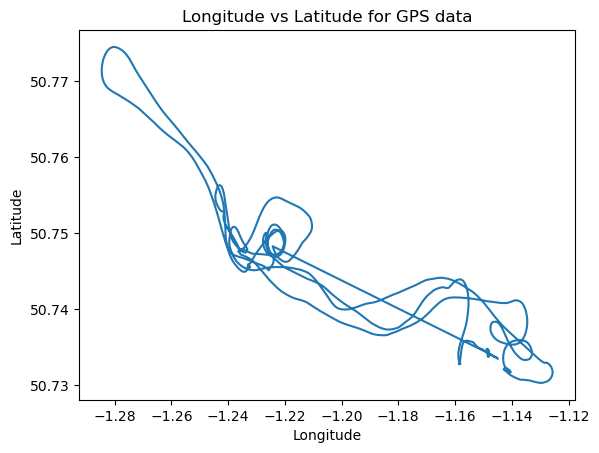

In [123]:
# Plot all lat and long data
plt.plot(gps_df['Lng'], gps_df['Lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Longitude vs Latitude for GPS data')
plt.show()


In [125]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Read in GPS data
gps_df = pd.read_csv('2023-12-12_131207_2000Turns.csv')
gps_df.head()

# Convert the "Time" column to datetime objects 
gps_df['Time'] = pd.to_datetime(gps_df['Time'], utc=True)

# Select the reference timestamp (e.g., the first entry in the DataFrame)
reference_timestamp = gps_df['Time'].iloc[121]
print(reference_timestamp)

# Calculate the time difference from the reference timestamp for each row
gps_df['time_from_sync'] = (gps_df['Time'] - reference_timestamp).dt.total_seconds()

gps_df.head()

# Define experiments with start and end times in a more structured way
experiments = [
    {"name": "001_Synchronisation", "start": -121, "end": 9},
    {"name": "002_Setup", "start": 9, "end": 95},
    {"name": "003_Waiting_for_departure", "start": 95, "end": 282},
    {"name": "004_Seaway_departure", "start": 282, "end": 300},
    {"name": "005_Departure", "start": 300, "end": 590},
    {"name": "006_Departure_cruise", "start": 590, "end": 790},
    {"name": "007_Fast_stbd_turn_1", "start": 790, "end": 920},
    {"name": "008_Interesting_roll_angle", "start": 920, "end": 995},
    {"name": "009_Fast_port_turn_1", "start": 995, "end": 1125},
    {"name": "010_Waiting_for_static_turns", "start": 1125, "end": 1255},
    {"name": "011_Static_stbd_1", "start": 1255, "end": 1310},
    {"name": "012_Static_port_1", "start": 1310, "end": 1390},
    {"name": "013_Static_port_2", "start": 1382, "end": 1450},
    {"name": "014_Static_stbd_2", "start": 1430, "end": 1500},
    {"name": "015_Intermediate_travel", "start": 1525, "end": 1550},
    {"name": "016_Straight_cruise_1", "start": 1550, "end": 1638},
    {"name": "017_Slight_turn_1", "start": 1638, "end": 1715},
    {"name": "018_Straight_cruise_2", "start": 1715, "end": 1824},
    {"name": "019_Turn_stbd_1", "start": 1824, "end": 1930},
    {"name": "020_Straight_cruise_3", "start": 1930, "end": 2140},
    {"name": "021_Quarter_turn_port", "start": 2140, "end": 2185},
    {"name": "022_Quarter_turn_stbd", "start": 2185, "end": 2290},
    {"name": "023_Eigth_turn_port", "start": 2290, "end": 2440},
    {"name": "024_Eigth_turn_stbd", "start": 2440, "end": 2530},
    {"name": "025_Tavel_to_sweep", "start": 2530, "end": 2695},
    {"name": "026_Engine_rpm_sweep", "start": 2695, "end": 2820},
    {"name": "027_Interim", "start": 2820, "end": 2885},
    {"name": "028_Return_to_ryde", "start": 2885, "end": 7505},
    {"name": "029_Engine_off_clean_up", "start": 7505, "end": 8374},
    {"name": "030_Post_flight_sync", "start": 8374, "end": 8495}
]

# Save the GPS data into separate files for each experiment
for experiment in experiments:
    start_time = experiment['start']
    end_time = experiment['end']
    experiment_name = experiment['name']

    dir_path = f"Experiments/{experiment_name}/GPS"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    filtered_df = gps_df[(gps_df['time_from_sync'] >= start_time) & (gps_df['time_from_sync'] < end_time)]

    file_name = f"GPS_{experiment_name}.csv"
    filtered_df.to_csv(os.path.join(dir_path, file_name), index=False)

# Dictionary to hold GPS data for each experiment
gps_data = {}

# Load GPS data for each experiment using parallel processing
def load_experiment_data(experiment):
    experiment_name = experiment['name']
    # Define the file path
    file_path = os.path.join("Experiments", experiment_name, "GPS", f"GPS_{experiment_name}.csv")
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Ensure required columns exist
        if {'Lng', 'Lat'}.issubset(df.columns):
            return experiment_name, df
        else:
            print(f"Warning: 'Lng' and/or 'Lat' columns missing in {file_path}.")
    else:
        print(f"Warning: File not found - {file_path}")
    return experiment_name, None

results = Parallel(n_jobs=-1)(delayed(load_experiment_data)(experiment) for experiment in experiments)

gps_data = {experiment_name: df for experiment_name, df in results if df is not None}

# Plotting and saving high-resolution images for each experiment
for i, experiment in enumerate(experiments):
    experiment_name = experiment['name']
    fig = plt.figure(figsize=(12, 8))
    # Plot all experiments in light grey
    for other_experiment, other_df in gps_data.items():
        plt.plot(other_df['Lng'], other_df['Lat'], color='lightgrey', linewidth=1, alpha=0.7)

    # Highlight the current experiment in a distinct color (e.g., red)
    current_df = gps_data.get(experiment_name)
    if current_df is not None:
        plt.plot(current_df['Lng'], current_df['Lat'], color='red', linewidth=2, label=experiment_name)
    
    # Configure plot aesthetics
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GPS Path for {experiment_name}')
    plt.grid(True)
    plt.legend()
    
    # Define the save path
    save_dir = os.path.join("Experiments", experiment_name, "GPS")
    save_path = os.path.join(save_dir, f"GPS_Path_{experiment_name}.png")
    
    # Save the figure with high resolution
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Saved high-resolution GPS plot for {experiment_name} at {save_path}")


2023-12-12 13:14:25.999000+00:00
Saved high-resolution GPS plot for 001_Synchronisation at Experiments\001_Synchronisation\GPS\GPS_Path_001_Synchronisation.png
Saved high-resolution GPS plot for 002_Setup at Experiments\002_Setup\GPS\GPS_Path_002_Setup.png
Saved high-resolution GPS plot for 003_Waiting_for_departure at Experiments\003_Waiting_for_departure\GPS\GPS_Path_003_Waiting_for_departure.png
Saved high-resolution GPS plot for 004_Seaway_departure at Experiments\004_Seaway_departure\GPS\GPS_Path_004_Seaway_departure.png
Saved high-resolution GPS plot for 005_Departure at Experiments\005_Departure\GPS\GPS_Path_005_Departure.png
Saved high-resolution GPS plot for 006_Departure_cruise at Experiments\006_Departure_cruise\GPS\GPS_Path_006_Departure_cruise.png
Saved high-resolution GPS plot for 007_Fast_stbd_turn_1 at Experiments\007_Fast_stbd_turn_1\GPS\GPS_Path_007_Fast_stbd_turn_1.png
Saved high-resolution GPS plot for 008_Interesting_roll_angle at Experiments\008_Interesting_roll_a

In [126]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define static turns to be plotted
target_experiments = ["011_Static_stbd_1", "012_Static_port_1", "013_Static_port_2", "014_Static_stbd_2"]

# Plotting and saving zoomed-in images for each static turn
for experiment_name in target_experiments:
    # Load the GPS data for the experiment
    file_path = os.path.join("Experiments", experiment_name, "GPS", f"GPS_{experiment_name}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Ensure required columns exist
        if {'Lng', 'Lat'}.issubset(df.columns):
            # Create the plot
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(df['Lng'], df['Lat'], color='blue', linewidth=2)
            
            # Configure plot aesthetics
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_title(f'Zoomed-in GPS Path for {experiment_name}')
            ax.grid(True)
            
            # Define the save path
            save_dir = os.path.join("Experiments", experiment_name, "GPS")
            save_path = os.path.join(save_dir, f"GPS_Zoomed_Path_{experiment_name}.png")
            
            # Save the figure with high resolution
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
            
            print(f"Saved zoomed-in GPS plot for {experiment_name} at {save_path}")
        else:
            print(f"Warning: 'Lng' and/or 'Lat' columns missing in {file_path}.")
    else:
        print(f"Warning: File not found - {file_path}")

# Stitching together 011, 012, 013, and 014 and saving the plot in the 011 folder
experiment_paths = [
    os.path.join("Experiments", "011_Static_stbd_1", "GPS", "GPS_011_Static_stbd_1.csv"),
    os.path.join("Experiments", "012_Static_port_1", "GPS", "GPS_012_Static_port_1.csv"),
    os.path.join("Experiments", "013_Static_port_2", "GPS", "GPS_013_Static_port_2.csv"),
    os.path.join("Experiments", "014_Static_stbd_2", "GPS", "GPS_014_Static_stbd_2.csv")
]

valid_dataframes = []

# Load data for all experiments
for path in experiment_paths:
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Ensure required columns exist
        if {'Lng', 'Lat'}.issubset(df.columns):
            valid_dataframes.append(df)
        else:
            print(f"Warning: 'Lng' and/or 'Lat' columns missing in {path}.")
    else:
        print(f"Warning: File not found - {path}")

# Create the stitched plot if all data is available
if len(valid_dataframes) == len(experiment_paths):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'orange']
    labels = ["011_Static_stbd_1", "012_Static_port_1", "013_Static_port_2", "014_Static_stbd_2"]
    
    for df, color, label in zip(valid_dataframes, colors, labels):
        ax.plot(df['Lng'], df['Lat'], color=color, linewidth=2, label=label)
    
    # Configure plot aesthetics
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Stitched GPS Path for 011, 012, 013, and 014')
    ax.grid(True)
    ax.legend()
    
    # Define the save path
    save_dir = os.path.join("Experiments", "011_Static_stbd_1", "GPS")
    save_path = os.path.join(save_dir, "GPS_Stitched_Path_011_012_013_014.png")
    
    # Save the figure with high resolution
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Saved stitched GPS plot for 011, 012, 013, and 014 at {save_path}")
else:
    print("Warning: Could not create stitched plot due to missing data.")


Saved zoomed-in GPS plot for 011_Static_stbd_1 at Experiments\011_Static_stbd_1\GPS\GPS_Zoomed_Path_011_Static_stbd_1.png
Saved zoomed-in GPS plot for 012_Static_port_1 at Experiments\012_Static_port_1\GPS\GPS_Zoomed_Path_012_Static_port_1.png
Saved zoomed-in GPS plot for 013_Static_port_2 at Experiments\013_Static_port_2\GPS\GPS_Zoomed_Path_013_Static_port_2.png
Saved zoomed-in GPS plot for 014_Static_stbd_2 at Experiments\014_Static_stbd_2\GPS\GPS_Zoomed_Path_014_Static_stbd_2.png
Saved stitched GPS plot for 011, 012, 013, and 014 at Experiments\011_Static_stbd_1\GPS\GPS_Stitched_Path_011_012_013_014.png


In [131]:
import nbformat as nbf
import os

# Load the notebook
nb = nbf.read('Afternoon_gps.ipynb', as_version=4)

# Create a new file
with open('output.py', 'w') as f:
    for cell in nb.cells:
        if cell.cell_type == 'code':
            f.write(cell.source + '\n\n')
        elif cell.cell_type == 'markdown':
            f.write('"""' + cell.source + '"""' + '\n\n')
        elif cell.cell_type == 'raw':
            f.write(cell.source + '\n\n')

In [132]:
import os

def generate_directory_overview(start_path, output_file):
    with open(output_file, 'w') as f:
        for root, dirs, files in os.walk(start_path):
            level = root.replace(start_path, '').count(os.sep)
            indent = ' ' * 4 * level
            f.write(f'{indent}{os.path.basename(root)}/\n')
            sub_indent = ' ' * 4 * (level + 1)
            for file in files:
                f.write(f'{sub_indent}{file}\n')

# Replace 'your_directory_path' with the path to the directory you want to process
start_directory = 'C:/Users/ben/Desktop/01_Seatrials/Ryde-seatrials-afternoon-turns-12-12-2023'
output_txt_file = 'directory_overview.txt'

generate_directory_overview(start_directory, output_txt_file)
print(f"Directory overview saved to {output_txt_file}")


Directory overview saved to directory_overview.txt
